# All SPCs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tabulate import tabulate

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

import qda

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller, kpss

## Helper functions

In [15]:
def is_corr_lagk_significant(k,data,COLNAME):
	# calculate the lag k from data
	data['lagk'] = data[COLNAME].shift(k)
	# calculate the difference between the data and the lagk
	data['diffk'] = data[COLNAME] - data['lagk']

	n = len(data['diffk'][k:])
	#autocorrelation function
	[acf_values, lbq, _] = acf(data['diffk'][k:], nlags = int(np.sqrt(n)), qstat=True, fft = False)
	# Bartlett's test at lag k
	# to check if lag k correlation is significant
	alpha = 0.05
	lag_test = k
	rk = acf_values[lag_test]
	z_alpha2 = stats.norm.ppf(1-alpha/2)
	print('Test statistic rk = %f' % rk)
	print('Rejection region is at +-%f' % (z_alpha2/np.sqrt(n)))

# Function for batching
def batch_data(data, k):
    data_batched = []
    for i in range(0, len(data), k):
        if i + k <= len(data):
            batch = data[i:i + k]
            avg = batch.mean()
            data_batched.append(avg)
    return pd.DataFrame(data_batched, columns=['x'])

# Function for gapping
def gap_data(data, k):
    data_gapped = data[::k]
    return pd.DataFrame(data_gapped, columns=['x'])

# Example usage:
data = pd.DataFrame({'x': range(1, 21)})  # Example dataset with 20 observations

# Batching with batch size 2
batch_size = 3
data_batched = batch_data(data['x'], batch_size)
print("Batched Data:")
print(data_batched)

# Gapping with gap size 2
gap_size = 3
data_gapped = gap_data(data['x'], gap_size)
print("Gapped Data:")
print(data_gapped)

Batched Data:
      x
0   2.0
1   5.0
2   8.0
3  11.0
4  14.0
5  17.0
Gapped Data:
     x
0    1
3    4
6    7
9   10
12  13
15  16
18  19


In [3]:
def check_gaussianity(data_points, title="",plotto=1):
	if str(type(data_points)) == "<class 'pandas.core.series.Series'>":
		data_points = data_points.dropna().values
	if plotto==1:
		plt.figure(figsize=(12,4))
		plt.subplot(1, 3, 1)
		stats.probplot(data_points,plot=plt)
		plt.subplot(1, 3, 2)
		# plt.hist(data_points)
		sns.histplot(data_points, kde=True, stat="density", linewidth=0)
		plt.subplot(1, 3, 3)
		plt.plot(data_points,'o-')
		plt.suptitle(f"{title}")
		plt.show()
	_, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({title}) Normality p-value = {shapiro_pvalue} - Normality at alpha 5%? {shapiro_pvalue>0.05}")
	print('H0 is "data are gaussian" => conclusion is good if pvalue is high')

def check_randomness(data_points, title="", plotto=1, layout="h"):
	if plotto==1:
		if layout=="v":
			fig, ax = plt.subplots(3,1, figsize=(8,12))
		else:
			fig, ax = plt.subplots(1,3, figsize=(12,4))
		sgt.plot_acf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[0])
		fig.subplots_adjust(hspace=0.3)
		sgt.plot_pacf(data_points, lags = int(len(data_points)/3), zero=False, ax=ax[1], method = 'ywm')
		ax[2].plot(data_points,'o-')
		plt.show()	
	_, pval_runs = runstest_1samp(data_points, correction=False)
	print(f'({title}) Runs test p-value = {pval_runs} - Random data at alpha 5%? {pval_runs>0.05}')
	print('H0 is "data are random" => conclusion is good if pvalue is high')
	#
	# and stationarity
	#
	# Perform ADF test
	adf_result = adfuller(data_points)
	adf_pvalue = adf_result[1]
	print(f"({title}) ADF test p-value = {adf_pvalue} - Stationarity at alpha 5%? {adf_pvalue <= 0.05}")
	print('H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low')

def check_assumptions(data_points, title="",plotto=1):
	check_gaussianity(data_points, title,plotto)
	check_randomness(data_points, title,plotto)

def check_residuals(model):
	fig, axs = plt.subplots(2, 2, figsize=(12, 7))
	fig.suptitle('Residual Plots')
	stats.probplot(model.resid, dist="norm", plot=axs[0, 0])
	axs[0, 0].set_title('Normal Probability Plot')
	axs[0, 1].scatter(model.fittedvalues, model.resid)
	axs[0, 1].set_xlabel('Fitted Values')
	axs[0, 1].set_ylabel('Residuals')
	axs[0, 1].set_title('Residuals vs Fitted Values')
	plt.subplot(2, 2, 3)
	sns.histplot(model.resid, kde=True, stat="density", linewidth=0)
	plt.title('Histogram with KDE')
	axs[1, 1].plot(np.arange(1, len(model.resid) + 1), model.resid, 'o-')
	axs[1, 1].set_title('Residuals Over Time')
	_, pval_SW_res = stats.shapiro(model.resid)
	plt.tight_layout()
	plt.subplots_adjust(top=0.88, hspace=0.3) 
	check_randomness(model.resid, title="Residuals")
	check_gaussianity(model.resid, title="Residuals", plotto=0)

def get_ooc(df):
    # Filter columns that contain the word "TEST"
    test_columns = [col for col in df.columns if "TEST" in col]
    # Initialize a dictionary to store the indices and their corresponding columns with NaNs
    nan_info = {}
    # Iterate over the test columns to find NaN values
    for col in test_columns:
        nan_indices = df[col].index[df[col].notnull()].tolist()
        for idx in nan_indices:
            if idx in nan_info:
                nan_info[idx].append(col)
            else:
                nan_info[idx] = [col]
    # Print the results
    for idx, cols in nan_info.items():
        print(f'Index {idx} (ie sample {idx+1}) is ooc from column {cols}')

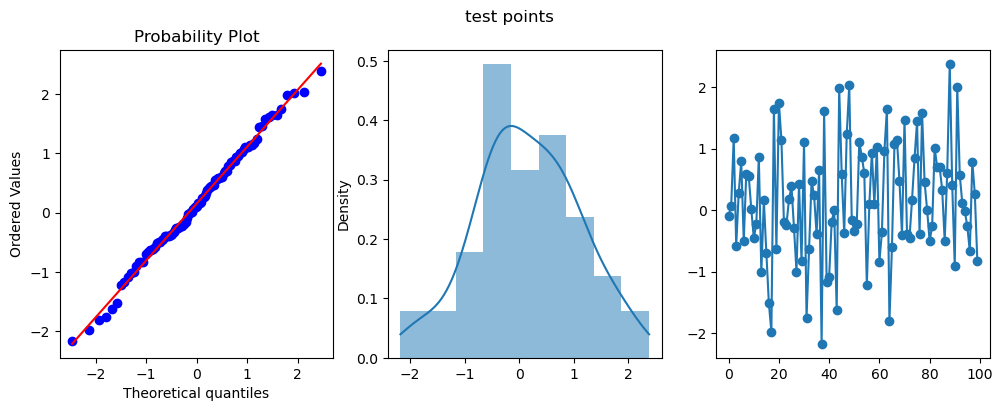

(test points) Normality p-value = 0.8915513157844543 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


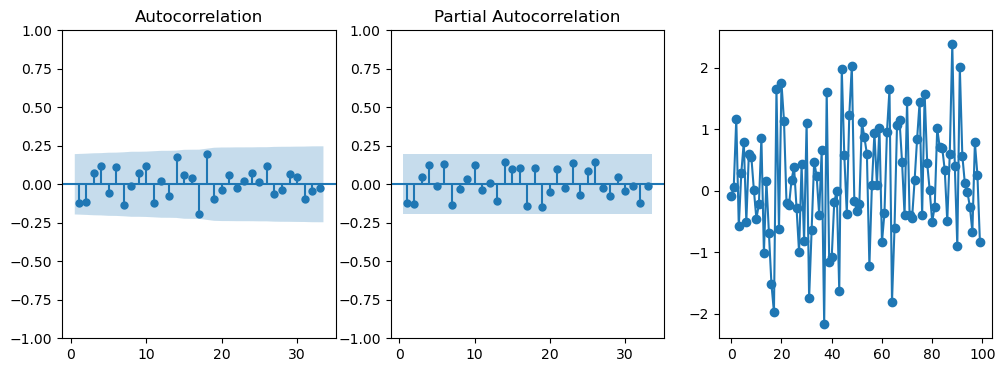

(test points) Runs test p-value = 0.4188498227478985 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(test points) ADF test p-value = 4.791783973092407e-20 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low


In [162]:
vals = np.random.randn(100)
check_gaussianity(vals,title="test points",plotto=1)
check_randomness(vals,title="test points",plotto=1,layout="h")

## Python utilities
In uppercase the parts that should be changed, according to the specific use context.  
Random variables functions:

- pdf(x): Computes the probability density function at x (for continuous distributions).
- cdf(x): Computes the cumulative distribution function at x.
- ppf(q): Computes the inverse of the CDF (quantile function) at q.
- sf(x): Computes the survival function (1 - CDF) at x.
- isf(q): Computes the inverse of the survival function at q.
- rvs(size=n): Generates n random variates.
- mean(): Computes the mean of the distribution.
- var(): Computes the variance of the distribution.
- std(): Computes the standard deviation of the distribution.
- moment(n): Computes the n-th moment about the mean.
- entropy(): Computes the differential entropy of the distribution.
- median(): Computes the median of the distribution.
- interval(alpha): Computes the confidence interval with a confidence level alpha.

In [ ]:
##### Lambda functions
lambda arguments: expression
# so for example
add = lambda x, y: x + y
numbers = [1, 2, 3, 4, 5]
squares = list(map(lambda x: x ** 2, numbers))
evens = list(filter(lambda x: x % 2 == 0, numbers))

##### normal quantiles
# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
print("alpha:",alpha,"\nK_alpha:",K_alpha)

##### Create a dataset
df = pd.DataFrame({
	'x': range(1, 6),
	'y': [6, 7, 8, 9, 10]
	})
# accessing column/columns
df['x']
df[['x']]
# subsetting rows
df[df['x'] > 2]

##### Import the dataset
df = pd.read_csv('PATH/TO/FILE.CSV')
df.head()

##### Stack data into single column
data_stack = df.stack() 
##### Standardize the data
data_std = (df - df.mean()) / df.std()

##### Break single column data in different samples (ie batching)
m=10 # number of samples
n=4  # observations in each sample
df=np.array(df['COLUMN']).reshape(m,n)
df=pd.DataFrame(df)
df.head()

##### Change all columns names
new_columns = ['new_col1', 'new_col2', 'new_col3']
df.columns = new_columns
##### Change specific columns names
df = df.rename(columns={'col1': 'new_col1', 'col2': 'new_col2'})

# When axis=0 is specified, the operation is performed along the rows (i.e., column by column). ↓
# When axis=1 is specified, the operation is performed along the columns (i.e., row by row). →

#### Plots stuff (colors, styles, lines)
plt.plot(df['x'], df['y'])
plt.plot(df['x'], df['y'], marker='o', linestyle='--', color='green')
plt.scatter(df['x'], df['y'], c=df['z'], cmap='viridis', s=df['z']*10)
plt.colorbar()  # Show color scale
plt.axhline(y=5, color='blue', linestyle='--')
plt.axvline(x=3, color='red', linestyle='--')
plt.title("Plot Title")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.show()

#### distributions
stats.expon
stats.gamma
stats.beta
stats.uniform
stats.lognorm
stats.t
stats.f
stats.binomial
stats.poisson
stats.geom

In [2]:
# whi K=3?
alpha = 0.0027
stats.norm.ppf(1-alpha/2)

2.9999769927034015

# ■ SPC iid (Lab 6)

<!-- ## XbarR -->
## Case n>1
<!-- Used for the case n>1 with estimated parameters.   -->
So here data.head() will give a matrix of data, where each row is a sample, and inside each row there are the n observations for that sample.

In [5]:
data = pd.read_csv("./Lab6/ESE06_ex1.csv")
data.head()

,x1,x2,x3,x4,x5
0,10.10,10.04,10.13,9.98,10.14
1,10.28,10.13,9.78,9.94,9.83
2,9.95,10.36,9.90,9.96,9.96
3,9.88,9.89,9.98,9.74,10.14
4,10.12,9.83,10.14,9.81,9.86


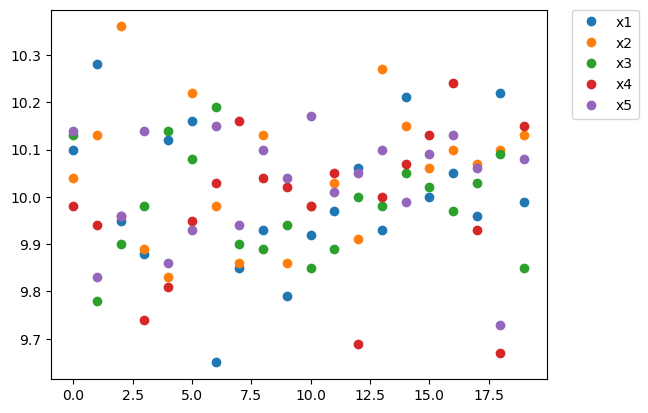

In [19]:
# Scatter plot of all the columns against the index
plt.plot(data['x1'], linestyle='none', marker='o', label = 'x1')
plt.plot(data['x2'], linestyle='none', marker='o', label = 'x2')
plt.plot(data['x3'], linestyle='none', marker='o', label = 'x3')
plt.plot(data['x4'], linestyle='none', marker='o', label = 'x4')
plt.plot(data['x5'], linestyle='none', marker='o', label = 'x5')
# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

1. There should not be strange patterns or outliers (otherwise go to SPC non iid section), between the samples (so going horizontally morally) and witihin the samples (so checking vertically).  
2. We might also check randomness **but** we would need to know the within-sample order!  
If we knew it we can just stack the data and check randomness assumption on the big vector generated.
3. So we just check normality, on all data points (ie stacking them, getting the big vector mentioned also in point 2).

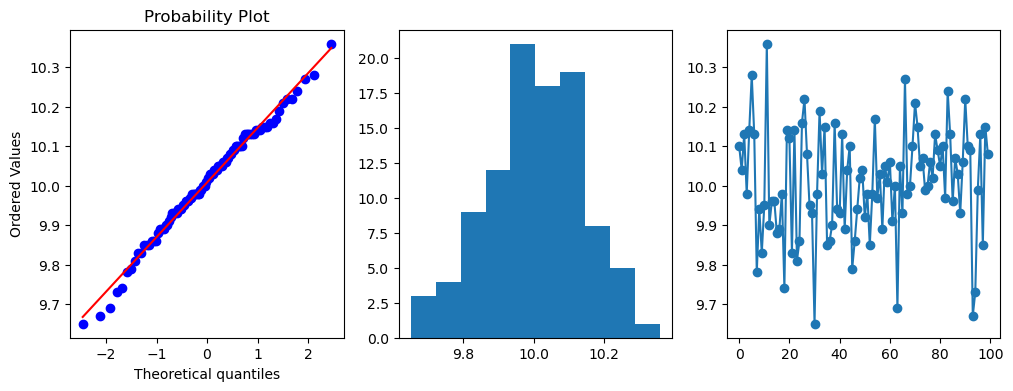

() Normality p-value = 0.7534034848213196 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [20]:
data_stack = data.stack()
check_gaussianity(data_stack)

### Box Cox
If we dont have normality we transform the data using Box Cox.
$$x_{BC,i} = \left\{ \begin{array}{ll} \frac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \ln x_i & \text{if } \lambda = 0 \end{array} \right.$$

Lambda = 7.058


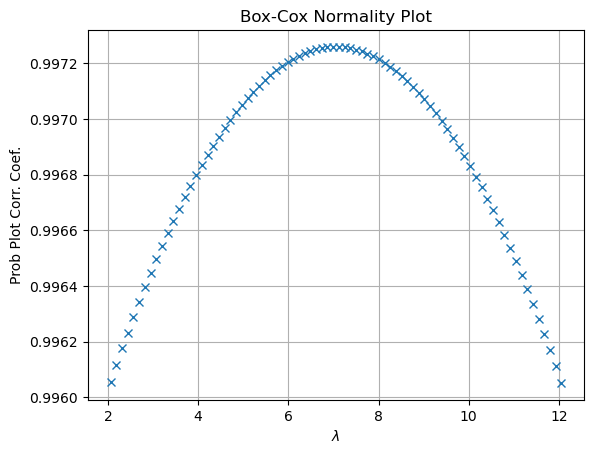

In [98]:
data_stack = data.stack()

# Box-Cox transformation and return the transformed data
[data_BC, lmbda] = stats.boxcox(data_stack)
print('Lambda = %.3f' % lmbda)
# Use this if we want to set the lambda manually
# data_BC = stats.boxcox(data_stack, lmbda=CHOSEN_VALUE)

# Use this to find the best value of lambda for the transformation
fig = plt.figure()
ax = fig.add_subplot(111)
stats.boxcox_normplot(data_stack, lmbda-5, lmbda+5, plot=ax)
ax.grid(True)

# Come back to the original structure of the dataset, ie unstack the data
data_BC_unstack = data_BC.reshape(data.shape)
# and convert it to a DataFrame
data_BC = pd.DataFrame(data_BC_unstack, columns = data.columns)

### Xbar-R

In [ ]:
# Create the control chart with the data
data_XR = qda.ControlCharts.XbarR(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarR(data, K = K_alpha)

### Manually
 **$\mathbf{\bar{X}}$ chart**:
 - $UCL = \overline{\overline{X}} + z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$
 - $CL = \overline{\overline{X}}$
 - $LCL = \overline{\overline{X}} - z_{\alpha/2} \frac{1}{d_2 \sqrt{n}} \overline{R}$

 **$R$ chart**:
 - $UCL = \overline{R} + z_{\alpha/2} \frac{d_3}{d_2} \overline{R}$
 - $CL = \overline{R}$
 - $LCL = max(0;\ \overline{R} - z_{\alpha/2} \frac{d_3}{d_2} \overline{R})$

In [21]:
# Make a copy of the data
data_XR = data.copy()

# Compute mean and range of the rows
data_XR['sample_mean'] = data.mean(axis=1)
data_XR['sample_range'] = data.max(axis=1) - data.min(axis=1)

# Inspect the dataset
print(data_XR.head())

Xbar_mean = data_XR['sample_mean'].mean() # grand mean
R_mean = data_XR['sample_range'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % R_mean)

      x1     x2     x3    x4     x5  sample_mean  sample_range
0  10.10  10.04  10.13  9.98  10.14       10.078          0.16
1  10.28  10.13   9.78  9.94   9.83        9.992          0.50
2   9.95  10.36   9.90  9.96   9.96       10.026          0.46
3   9.88   9.89   9.98  9.74  10.14        9.926          0.40
4  10.12   9.83  10.14  9.81   9.86        9.952          0.33
Mean of the sample mean: 10.008
Mean of the sample range: 0.314


3.090232306167813


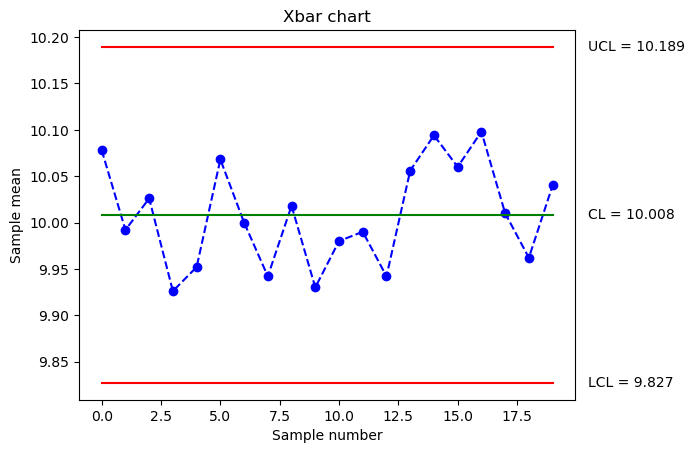

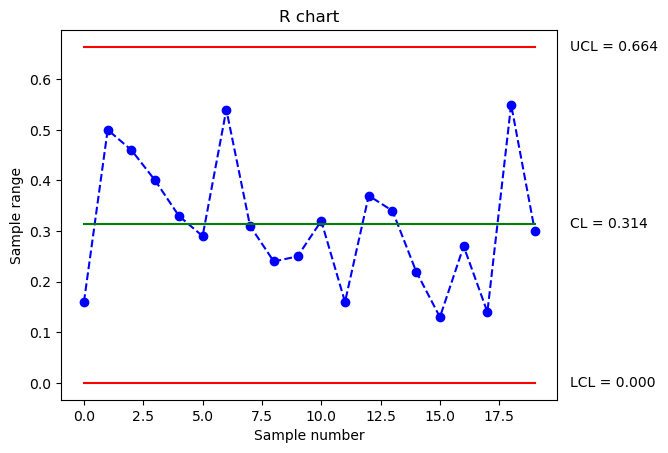

In [28]:
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2) 
# quantiles are with alpha the probability remained on the right of the value
# ie upper quantiles
print(K_alpha)

# Vd tabella alla fine per valori
n = 5
A2 = 0.577
D3 = 0
D4 = 2.114

# Now we can compute the CL, UCL and LCL for Xbar and R
data_XR['Xbar_CL'] = Xbar_mean
data_XR['Xbar_UCL'] = Xbar_mean + A2 * R_mean
data_XR['Xbar_LCL'] = Xbar_mean - A2 * R_mean

data_XR['R_CL'] = R_mean
data_XR['R_UCL'] = D4 * R_mean
data_XR['R_LCL'] = D3 * R_mean

data_XR['Xbar_TEST1'] = np.where(
	(data_XR['sample_mean'] > data_XR['Xbar_UCL']) | (data_XR['sample_mean'] < data_XR['Xbar_LCL']),
	data_XR['sample_mean'], np.nan)
data_XR['R_TEST1'] = np.where(
	(data_XR['sample_range'] > data_XR['R_UCL']) | (data_XR['sample_range'] < data_XR['R_LCL']), 
	data_XR['sample_range'], np.nan)

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XR['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['Xbar_UCL'], color='r')
plt.plot(data_XR['Xbar_CL'], color='g')
plt.plot(data_XR['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the R chart
plt.title('R chart')
plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['R_UCL'], color='r')
plt.plot(data_XR['R_CL'], color='g')
plt.plot(data_XR['R_LCL'], color='r')
plt.ylabel('Sample range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### Estimate variance and CI
Variance estimate trhough R:
$$\hat{\sigma} = \frac{\bar{R}}{d_2(n)}$$
CI: $$\bar{X} - z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}} \leq \mu \leq \bar{X} + z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{n}}$$

In [45]:
# Estimate sigma_hat through R statistic
d2 = qda.constants.getd2(n) # to get d2
sigma_hat = R_mean / d2
print('Sigma_hat = %.3f' % sigma_hat)

# Estimate confidence interval (control limits) 
CI = stats.norm.interval(1-alpha, loc=Xbar_mean, scale=sigma_hat/np.sqrt(n))
print('CI = (%.3f, %.3f)' % CI)

Sigma_hat = 0.135
CI = (9.822, 10.195)


### Table of constants
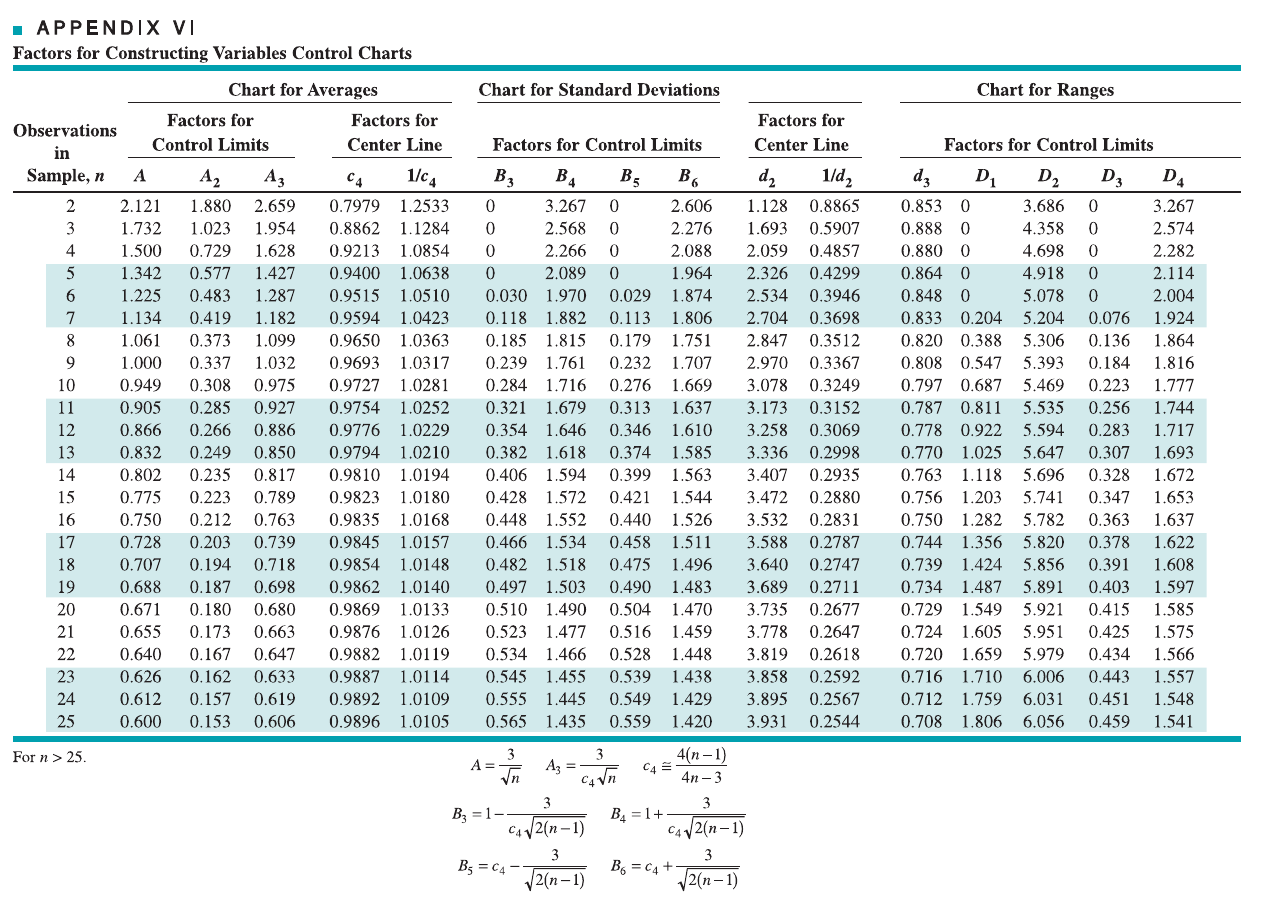

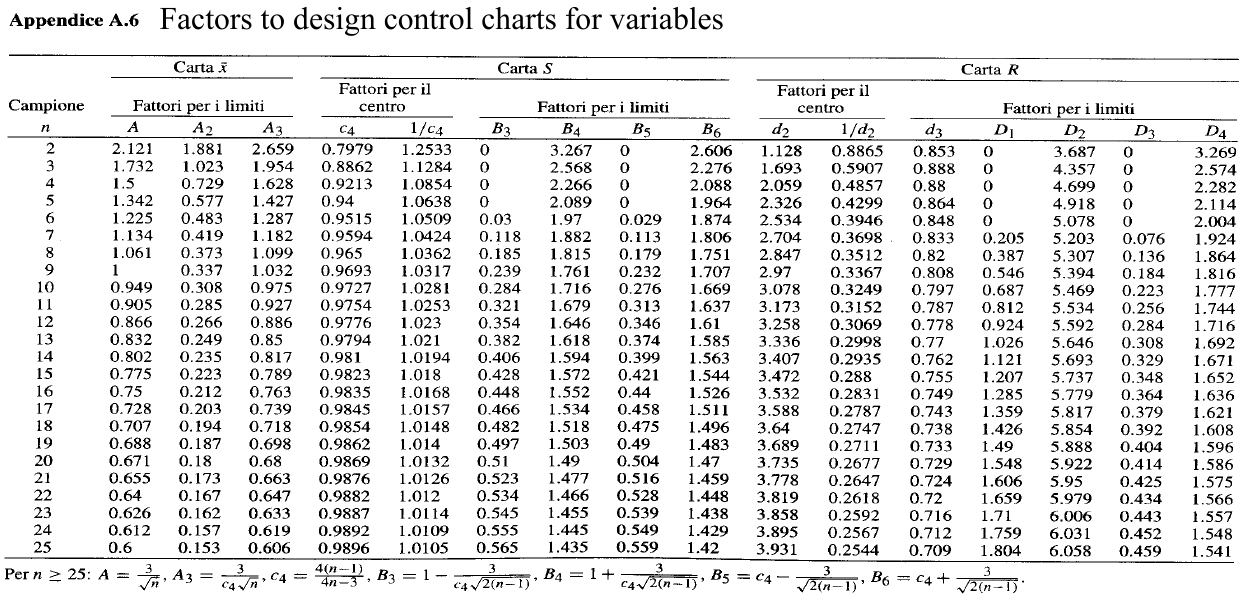

### OC curve
$$\beta = P(Z \leq K - \delta \sqrt{n}) - P(Z \leq -K - \delta \sqrt{n}), \quad \delta = \frac{\mu_1-\mu_0}{\sigma}$$

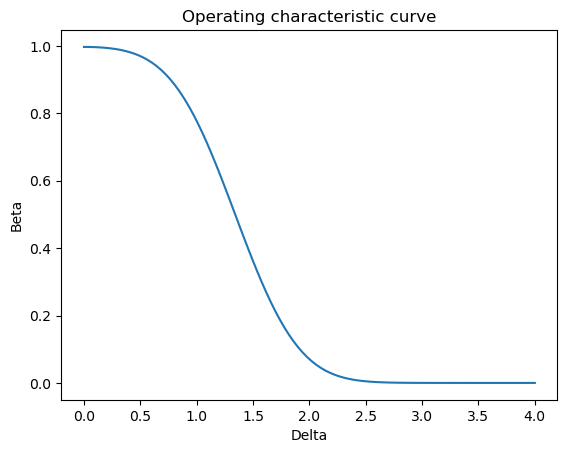

In [32]:
n=data.shape[1] # maybe this also work
# n=SET_N_FROM_DATA
# Define a range of values for beta
delta = np.linspace(0, 4, 100)
# Compute the corresponding beta values
beta = stats.norm.cdf(3 - delta*np.sqrt(n)) - stats.norm.cdf(-3 - delta*np.sqrt(n))
# Plot the beta values
plt.plot(delta, beta)
plt.xlabel('Delta')
plt.ylabel('Beta')
plt.title('Operating characteristic curve')

# repeat that code here to overlap multiple curves

plt.show()

### ARL curve
ARL is the expected number of samples that we need to wait (on average) before identifying that the process had a shift.
$$ARL = \frac{1}{1-\beta}$$

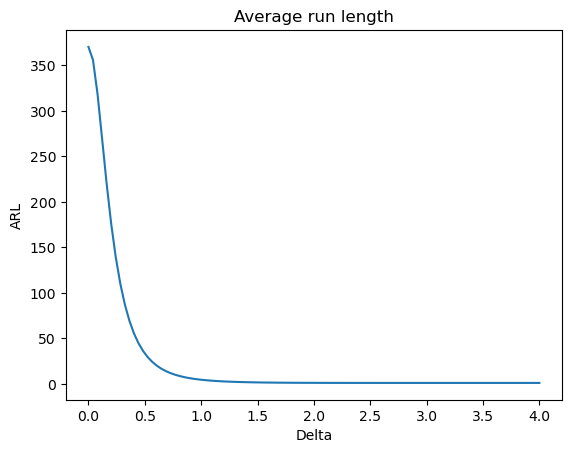

In [34]:
# Average run length ARL
ARL = 1/(1-beta)
# Plot the ARL values
plt.plot(delta, ARL)
plt.xlabel('Delta')
plt.ylabel('ARL')
plt.title('Average run length')
plt.show()

### ATS curve
We need to set 
$$ h = \frac{\text{every how much time}}{\text{how much we collect}}$$
and we have that $ \text{ATS}= h\cdot \text{ARL}$.

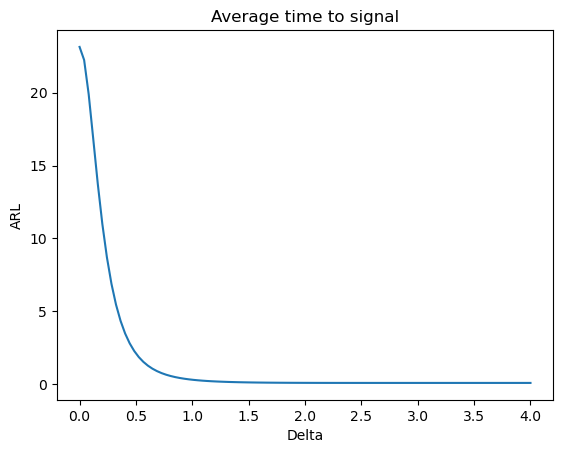

In [38]:
h = (1/2) / (8) # eg every half an hour we take 8 measurements
ATS = h * ARL
# Plot the ARL values
plt.plot(delta, ATS)
plt.xlabel('Delta')
plt.ylabel('ARL')
plt.title('Average time to signal')
plt.show()

### Xbar-S

In [ ]:
# X-bar and S charts
data_XS = qda.ControlCharts.XbarS(data)

# with different alpha/k
alpha = 0.002
K_alpha = stats.norm.ppf(1-alpha/2)
data_XR_alpha = qda.ControlCharts.XbarS(data, K = K_alpha)

### Manually

In [39]:
# Make a copy of the data
data_XS = data.copy()
# Add a column with the mean of the rows
data_XS['sample_mean'] = data.mean(axis=1)
# Add a column with the range of the rows
data_XS['sample_std'] = data.std(axis=1)

print(data_XS.head())

Xbar_mean = data_XS['sample_mean'].mean()
S_mean = data_XS['sample_std'].mean()

print('Mean of the sample mean: %.3f' % Xbar_mean)
print('Mean of the sample range: %.3f' % S_mean)

      x1     x2     x3    x4     x5  sample_mean  sample_std
0  10.10  10.04  10.13  9.98  10.14       10.078    0.067231
1  10.28  10.13   9.78  9.94   9.83        9.992    0.209690
2   9.95  10.36   9.90  9.96   9.96       10.026    0.188361
3   9.88   9.89   9.98  9.74  10.14        9.926    0.147241
4  10.12   9.83  10.14  9.81   9.86        9.952    0.163615
Mean of the sample mean: 10.008
Mean of the sample range: 0.130


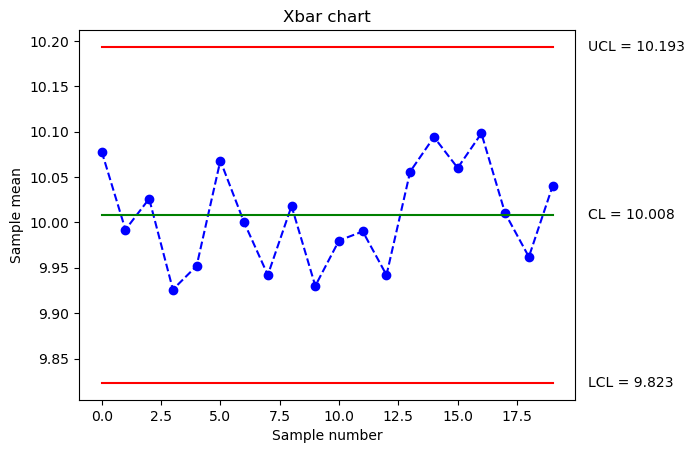

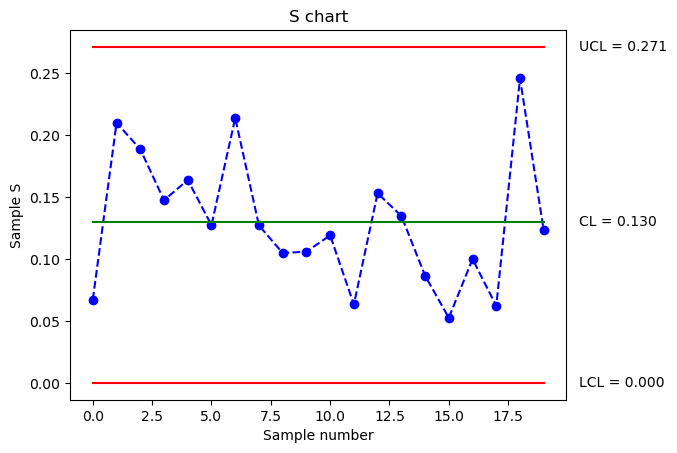

In [40]:
n = data.shape[1]
K = 3
A3 = K * 1 / (qda.constants.getc4(n) * np.sqrt(n))
B3 = np.maximum(1 - K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n)), 0)
B4 = 1 + K * (np.sqrt(1-qda.constants.getc4(n)**2)) / (qda.constants.getc4(n))

# Now we can compute the CL, UCL and LCL for Xbar and S
data_XS['Xbar_CL'] = Xbar_mean
data_XS['Xbar_UCL'] = Xbar_mean + A3 * S_mean
data_XS['Xbar_LCL'] = Xbar_mean - A3 * S_mean
data_XS['S_CL'] = S_mean
data_XS['S_UCL'] = B4 * S_mean
data_XS['S_LCL'] = B3 * S_mean
data_XS['Xbar_TEST1'] = np.where((data_XS['sample_mean'] > data_XS['Xbar_UCL']) | 
                (data_XS['sample_mean'] < data_XS['Xbar_LCL']), data_XS['sample_mean'], np.nan)
data_XS['S_TEST1'] = np.where((data_XS['sample_std'] > data_XS['S_UCL']) | 
                (data_XS['sample_std'] < data_XS['S_LCL']), data_XS['sample_std'], np.nan)
data_XS.head()

# Plot the Xbar chart
plt.title('Xbar chart')
plt.plot(data_XS['sample_mean'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['Xbar_UCL'], color='r')
plt.plot(data_XS['Xbar_CL'], color='g')
plt.plot(data_XS['Xbar_LCL'], color='r')
plt.ylabel('Sample mean')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['Xbar_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['Xbar_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['Xbar_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['Xbar_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['Xbar_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['Xbar_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# Plot the S chart
plt.title('S chart')
plt.plot(data_XS['sample_std'], color='b', linestyle='--', marker='o')
plt.plot(data_XS['S_UCL'], color='r')
plt.plot(data_XS['S_CL'], color='g')
plt.plot(data_XS['S_LCL'], color='r')
plt.ylabel('Sample S')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XS)+.5, data_XS['S_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XS['S_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_CL'].iloc[0], 'CL = {:.3f}'.format(data_XS['S_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XS)+.5, data_XS['S_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XS['S_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XS['S_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

## Case n=1
So no we deal with individual data.

In [42]:
data = pd.read_csv("./Lab6/ESE06_ex3.csv")
COL_NAME = "GM"
data.head()

,GM
0,-0.875
1,2.437
2,-1.187
3,-2.063
4,0.938


1. Verify randomness assumption.
2. Verify normality assumption.

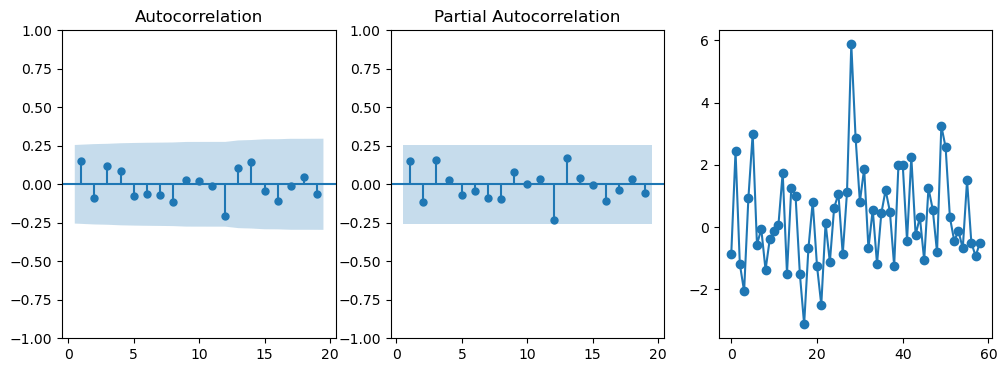

() Runs test p-value = 0.8793778294331255 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
() ADF test p-value = 1.6203979687323668e-08 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low


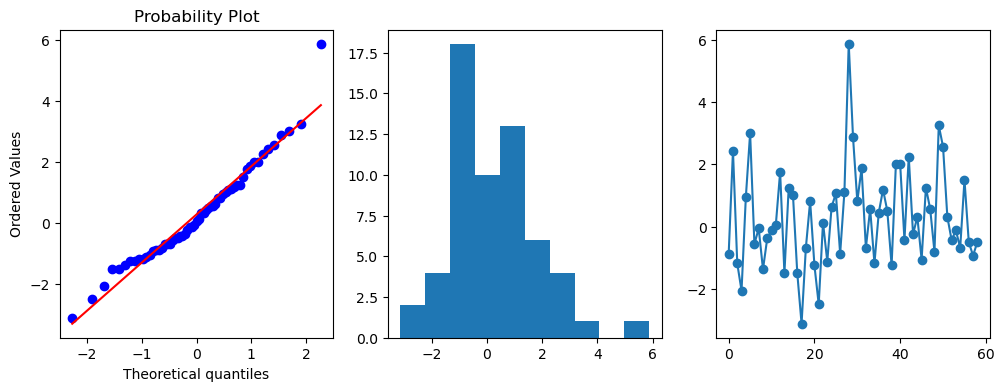

() Normality p-value = 0.06757929176092148 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [51]:
check_randomness(data[COL_NAME])
check_gaussianity(data[COL_NAME])

### I-MR

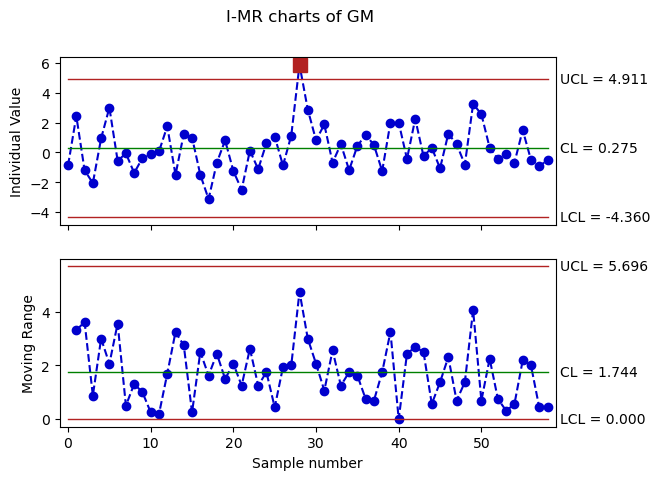

In [52]:
data_IMR = qda.ControlCharts.IMR(data, COL_NAME)

### Manually

Now we can proceed with the charts.  
 **I chart**:
 - $UCL = \bar{x} + 3 \left(\frac{\bar{MR}}{d_2} \right)$
 - $CL = \bar{x}$
 - $LCL = \bar{x} - 3 \left(\frac{\bar{MR}}{d_2} \right)$
 
 **MR chart**:
 - $UCL = D_4 \bar{MR}$
 - $CL = \bar{MR}$
 - $LCL = 0$

In [55]:
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

       I     MR
0 -0.875    NaN
1  2.437  3.312
2 -1.187  3.624
3 -2.063  0.876
4  0.938  3.001


       I     MR     I_UCL      I_CL     I_LCL    MR_UCL     MR_CL  MR_LCL  \
0 -0.875    NaN  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
1  2.437  3.312  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
2 -1.187  3.624  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
3 -2.063  0.876  4.912667  0.275424 -4.361819  5.696352  1.743603       0   
4  0.938  3.001  4.912667  0.275424 -4.361819  5.696352  1.743603       0   

   I_TEST1  MR_TEST1  
0      NaN       NaN  
1      NaN       NaN  
2      NaN       NaN  
3      NaN       NaN  
4      NaN       NaN  


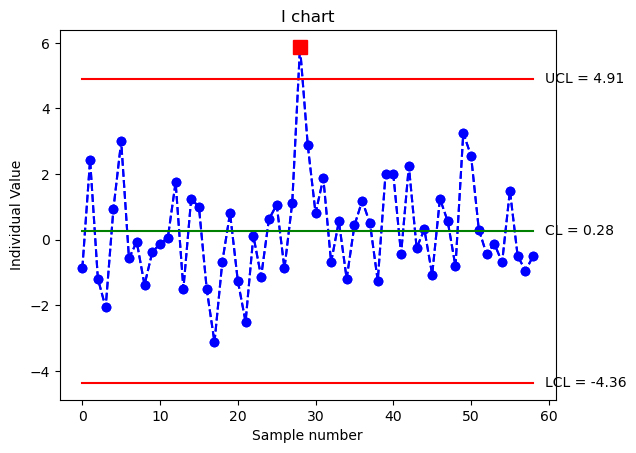

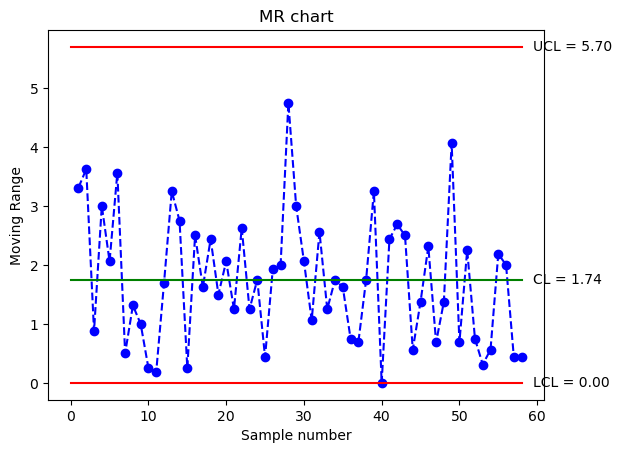

In [56]:
# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

### MR variants
Switch to these MR variants if there was an issue (an ooc signal) only in the MR chart.  
The MR follows a half Normal distribution, so those classical limits could not suit it very well and then given some errors which are actually not due to the data but to this wrong distr ass. In that case we could
> 1. switch to probability limits by using the half-normal approximation (morally an always correct choice)

 - $UCL = D_{1-\alpha/2} \frac{\bar{MR}}{d_2}$
 - $LCL = D_{\alpha/2} \frac{\bar{MR}}{d_2}$

 For $n=2$ (Alwan, Appendix A):
 - $D_{1-\alpha/2} = \sqrt{2} z_{alpha/4}$
 - $D_{\alpha/2} = \sqrt{2} z_{1/2 - alpha/4}$

In [58]:
alpha = 0.01
K_alpha = stats.norm.ppf(1-alpha/2)
print(K_alpha)

2.5758293035489004


MR_UCL = 6.1342
MR_LCL = 0.0137


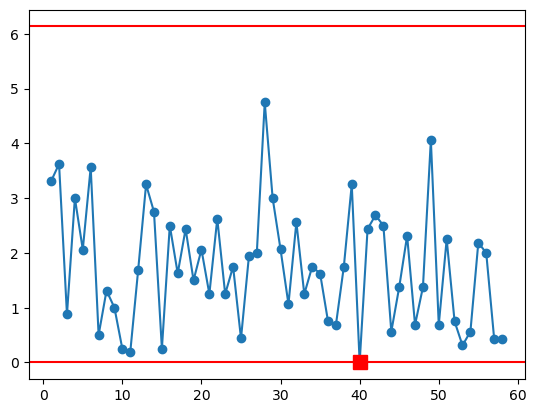

In [110]:
data['MR'] = data[COL_NAME].diff().abs()
D_UCL = np.sqrt(2) * stats.norm.ppf(1-alpha/4)
D_LCL = np.sqrt(2) * stats.norm.ppf(1 - (1/2 - alpha/4))

MR_UCL = D_UCL * data_IMR['MR'].mean()/qda.constants.getd2(2)
MR_LCL = D_LCL * data_IMR['MR'].mean()/qda.constants.getd2(2)

print('MR_UCL = %.4f' % MR_UCL)
print('MR_LCL = %.4f' % MR_LCL)

data_IMR['MR_TEST1'] = np.where(
	(data_IMR['MR'] > MR_UCL) | (data_IMR['MR'] < MR_LCL),
	data_IMR['MR'], np.nan)

plt.plot(data_IMR['MR'], 'o-')
plt.axhline(MR_UCL, color = 'r')
plt.axhline(MR_LCL, color = 'r')
plt.plot(data_IMR['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

We have an ooc but on the lower limit. So this is actually not necessary a problem, it just means that there are two successive obs with the same value. The real problem is when we go above the upper limit.

> 2. transform the variable with Box Cox and use on them the I chart

We know we can apply a known transformation ($\lambda = 0.4$).   
Attention: Box-Cox is not directly applicable to MR data because we have an observation equal to 0. 

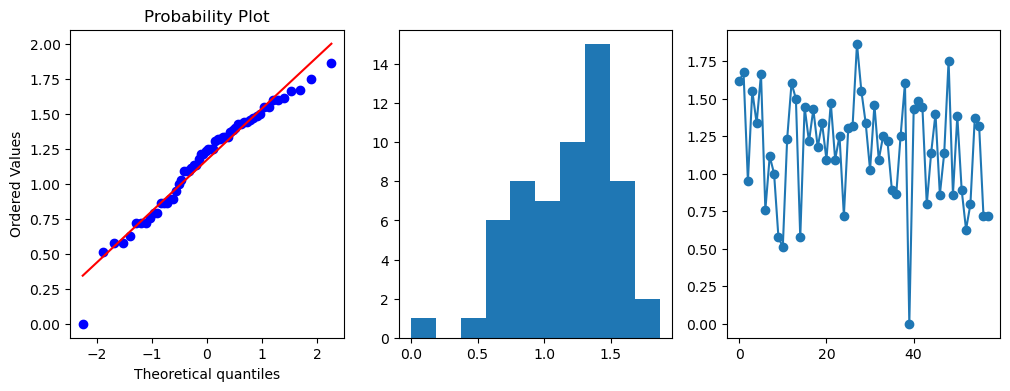

() Normality p-value = 0.11422736942768097 - Normality at alpha 5%? True
H0 is "data are not gaussian" => conclusion is good if pvalue is high


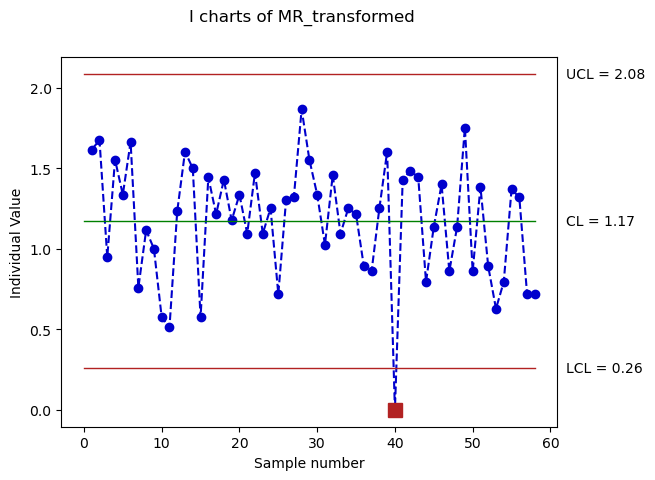

In [113]:
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])
# Get the index of the value equal to 0
idx = MR[MR['MR'] == 0].index[0]
# Change it to NaN
MR['MR'].iloc[idx] = np.nan

# Transform the data
MR['MR'] = MR['MR'].transform(lambda x: ((x**0.4)))
# or with Box Cox (?)
# [data_BC, lmbda] = stats.boxcox(MR['MR'])
# MR['MR'] = data_BC

# Replace the NaN value with 0
MR['MR'].iloc[idx] = 0

check_gaussianity(MR['MR'])
# Now use the classical I chart

# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = K_alpha, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()

### OOC signaled
What to do?  
- **if we have an assignable cause**: the data violating the charts was really out of control, so we should remove it and redesign the chart (as phase 1 assumes to be working only with in control data). 
- **if no assignable cause**: do nothing, it was a false alarm. It can happen. In case we want really to remove it we can tune the alpha, ie the K defining the widht of the charts. Otherwise that is in any case the final chart.

In [57]:
# find the index of the I_TEST1 column different from NaN -> ooc value index
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [28]


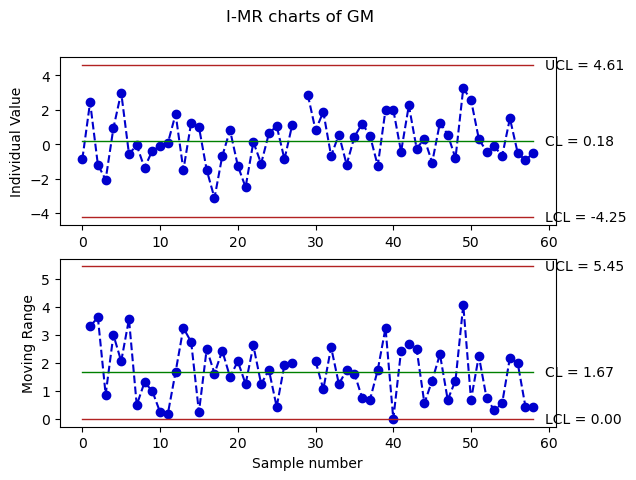

In [64]:
# New control chart without ooc value
# only if assignable cause, iterative procedure
data_2 = data.copy()
# replace the OOC point with NaN
data_2[COL_NAME].iloc[OOC_idx] = np.nan

# Plot the new control chart
data_IMR_2 = qda.ControlCharts.IMR(data_2, COL_NAME)

### Adding new observations

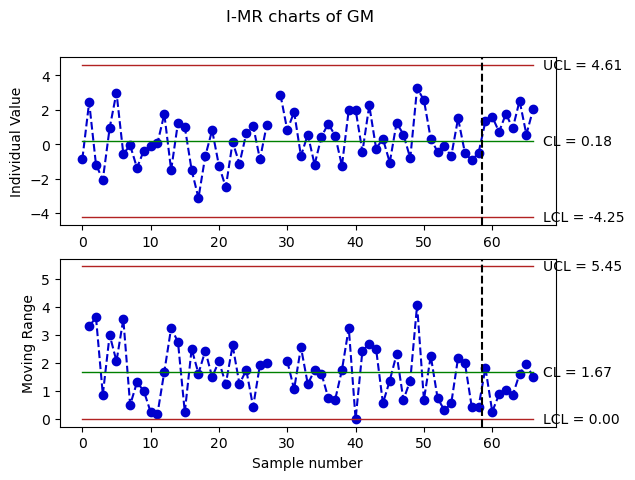

In [68]:
# Import the dataset
data = pd.read_csv('./Lab6/ESE06_ex3.csv')
# replace the OOC point with NaN
data[COL_NAME].iloc[OOC_idx] = np.nan

# Define the array with the new observations
new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))
# Add the new observations to the dataset
new_data = pd.concat([data, pd.DataFrame(new_obs, columns=['GM'])], ignore_index=True)
# new_data = data.append(pd.DataFrame(new_obs, columns=['GM']), ignore_index=True)

# Use the parameter `subset_size` to specify the number of observations to be used 
# for the computation of the control limits (Phase 1 data).
new_data_IMR = qda.ControlCharts.IMR(new_data, 'GM', subset_size=len(data))
# chart built only on old data, but new data plotted to see if in control
# black dotted line to separate old and new obs

# ■ SPC non iid (Lab 7)
When we see a trend or strange patterns in a control chart we build, it is probably due to a violation of the assumptions. That's why we should always check them. Anyway, in such cases the idea is to 
- fit a model on the data
- extract the residuals
- build a chart on the residuals  

if we believe that there is really a trend/behaviour in the data.  

All this part is related to the case $n=1$.   
So it is when we do the classical IMR chart code but we see a strange pattern in the chart.

## Regression models (LM)

     I     MR
0  600    NaN
1  480  120.0
2  540   60.0
3  240  300.0
4  420  180.0
     I     MR     I_UCL      I_CL   I_LCL    MR_UCL  MR_CL  MR_LCL  I_TEST1  \
0  600    NaN  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
1  480  120.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
2  540   60.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
3  240  300.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   
4  420  180.0  654.4926  325.7692 -2.9542  403.8012  123.6       0      NaN   

   MR_TEST1  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


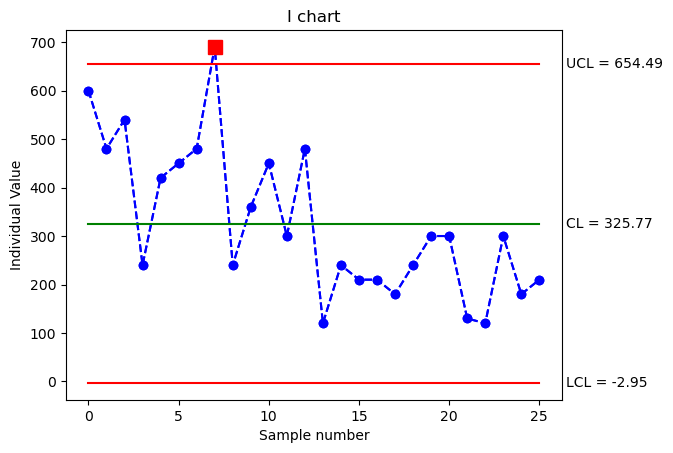

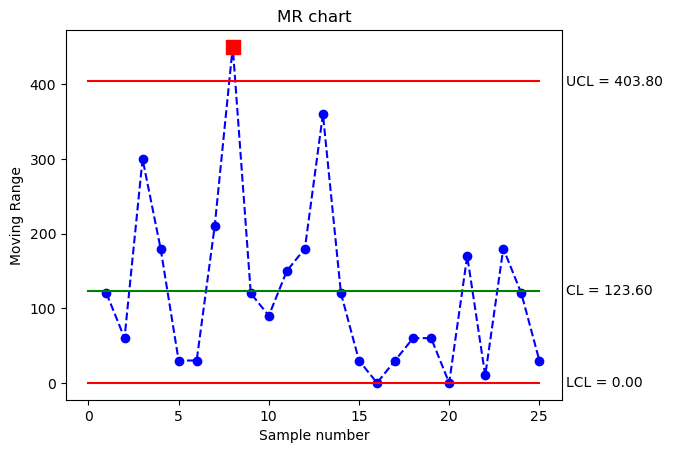

In [85]:
data = pd.read_csv("./Lab7/ESE7_ex1.csv")

###### taken from IMR section above
COL_NAME = "time"
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

print(df.head())

# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

We see something strange so we try to fit a model.  
Indeed the assumptions were not satisfied:

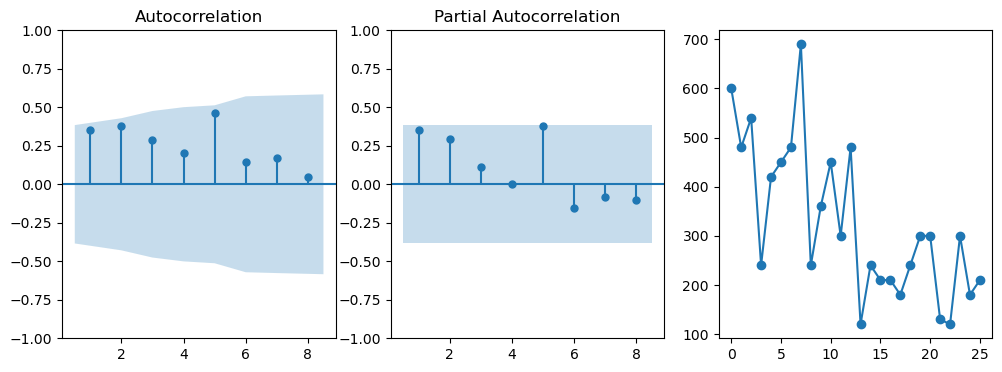

() Runs test p-value = 0.024475950275723145 - Random data at alpha 5%? False
H0 is "data are random" => conclusion is good if pvalue is high
() ADF test p-value = 0.007628747972657459 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low


In [86]:
check_randomness(data[COL_NAME])

### Fit model

In [87]:
# Add a column with the sample number to use as regressor
data['t'] = np.arange(1, len(data)+1)
# Other possible regressor: the value y_{t-k}
# data['temp_lag1'] = data['time'].shift(k)
print(data.head())

# Fit linear regression model
x = data['t']
x = sm.add_constant(x)
y = data['time']
model = sm.OLS(y,x).fit()

# Print model summary
qda.summary(model)

   time     MR  t
0   600    NaN  1
1   480  120.0  2
2   540   60.0  3
3   240  300.0  4
4   420  180.0  5
REGRESSION EQUATION
-------------------
time =  + 518.554 const -14.280 t

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 518.5538  45.5680  11.3798 3.7191e-11
    t -14.2803   2.9506  -4.8397 6.2424e-05

MODEL SUMMARY
-------------
       S   R-sq  R-sq(adj)
112.8402 0.4939     0.4728

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value    P-Value
Regression  1.0 2.9824e+05 2.9824e+05  23.4232 6.2424e-05
     const  1.0 1.6489e+06 1.6489e+06 129.4994 3.7191e-11
         t  1.0 2.9824e+05 2.9824e+05  23.4232 6.2424e-05
     Error 24.0 3.0559e+05 1.2733e+04      NaN        NaN
     Total 25.0 6.0383e+05        NaN      NaN        NaN


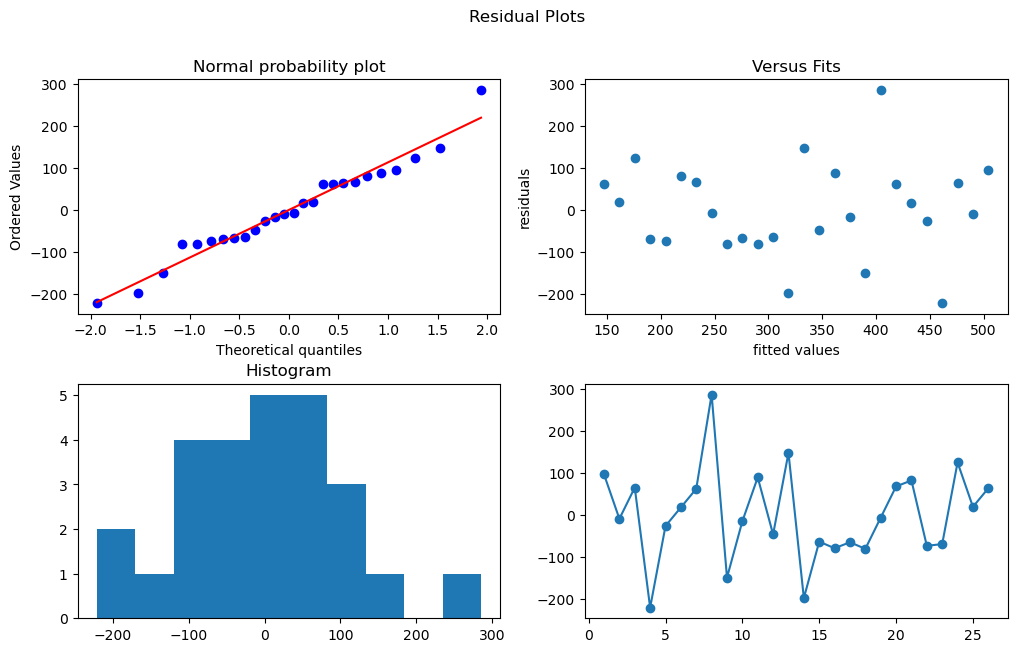

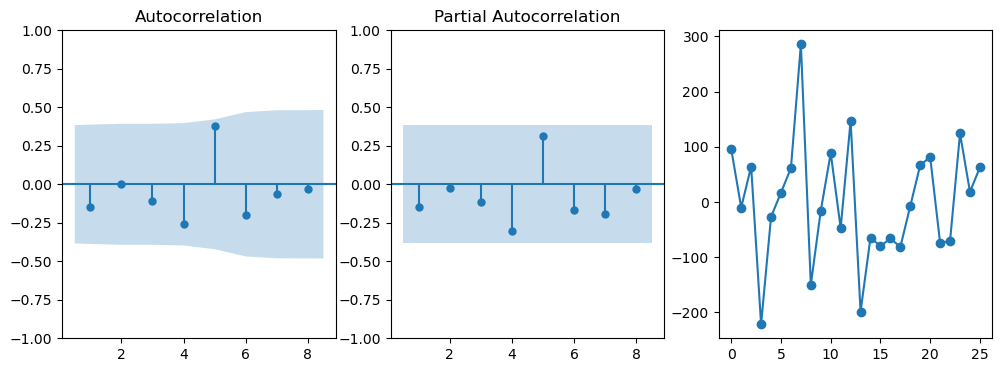

(residuals) Runs test p-value = 0.7100281378519226 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(residuals) ADF test p-value = 1.0016063083816604e-06 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low
(residuals) Normality p-value = 0.7004987597465515 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [88]:
check_residuals(model)
# directly access residuals with model.resid

### Trend chart
A TREND control chart will be based on the residuals of the trend model.  
And let's use the MR of the residuals.
$$UCL = \underbrace{\color{blue}\big(\beta_0 + \beta_1 \cdot t\big)}_{\text{fitted values}}\color{black}+ 3 \frac{\bar{MR}}{d_2 (2)}$$
$$CL = \color{blue}\big(\beta_0 + \beta_1 \cdot t\big) \color{black}$$
$$LCL = \color{blue}\big(\beta_0 + \beta_1 \cdot t \big) \color{black}- 3 \frac{\bar{MR}}{d_2 (2)}$$


In [89]:
df_res = pd.DataFrame({'I': model.resid})
df_res['MR'] = df_res['I'].diff().abs() # we use the MR of the residuals

print(df_res.head())

          I        MR
0   95.7265       NaN
1   -9.9932  105.7197
2   64.2872   74.2803
3 -221.4325  285.7197
4  -27.1521  194.2803


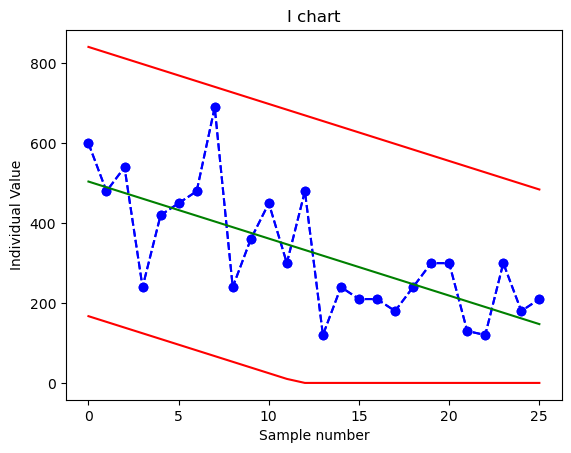

In [97]:
# make a copy of the data
# df = data.copy()
# or just extract the relevant variable
df = pd.DataFrame({'I': data[COL_NAME]})

# get constants
d2 = qda.constants.getd2(2)
D4 = qda.constants.getD4(2)
# d2 = 1.128 
# D4 = 3.267

# set limits
df['I_CL'] = model.fittedvalues
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * df_res['MR'].mean() / d2
df['I_LCL'] = df['I_CL'] - 3 * df_res['MR'].mean() / d2

# correction if values for their nature cant go below zero (for example)
df['I_LCL'] = np.where((df['I_LCL'] < 0), 0, df['I_LCL'])
# or similar correction wrt the variable at test

# Also update the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

### SCC
Special Cause control Chart. It carries the same information of the trend chart, but the trend gets complex to plot for complex trends, so this is more general, being the classical IMR on residuals.

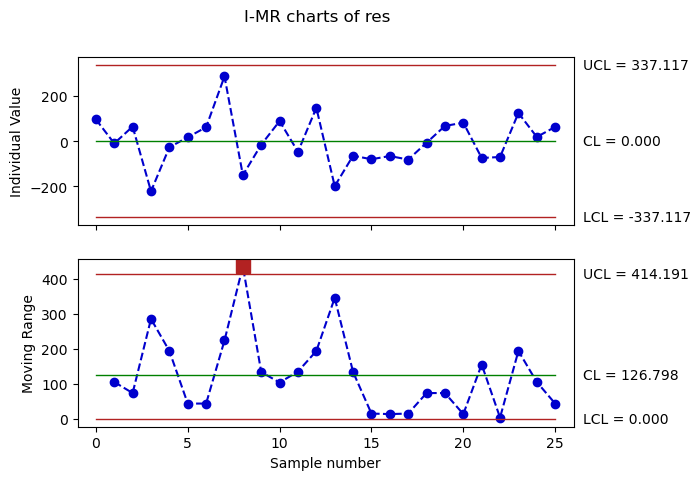

The index of the OOC point is: [8]


In [78]:
df_res = pd.DataFrame({'res': model.resid})
data_IMR = qda.ControlCharts.IMR(df_res, 'res')

# find the index of the I_TEST1 column different from NaN -> ooc value index
OOC_idx = np.where(data_IMR['MR_TEST1'].notnull())[0]
print('The index of the OOC point is: {}'.format(OOC_idx))

### Dummy variable
Now assume **we found an assignable cause** for the OOC observation 8 (if ass cause not found dont do this dummy procedure). We do this rather than removing the ooc obs since this approach may be better.   

We need to redesign the control charts by inserting a DUMMY VARIABLE such that:
- $\text{dummy} = 0$ for $t \neq 8$
- $\text{dummy} = 1$ for $t = 8$

and we refit the model.

   time     MR  t  dummy
0   600    NaN  1      0
1   480  120.0  2      0
2   540   60.0  3      0
3   240  300.0  4      0
4   420  180.0  5      0
REGRESSION EQUATION
-------------------
time =  + 491.459 const -13.138 t + 303.648 dummy

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 491.4591  40.4001  12.1648 1.6827e-11
    t -13.1384   2.5785  -5.0953 3.6839e-05
dummy 303.6483 100.5632   3.0195 6.1044e-03

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
97.5439 0.6376     0.6061

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS  F-Value    P-Value
Regression  2.0 3.8499e+05 1.9250e+05  20.2313 8.5294e-06
     const  1.0 1.4080e+06 1.4080e+06 147.9824 1.6827e-11
         t  1.0 2.4702e+05 2.4702e+05  25.9620 3.6839e-05
     dummy  1.0 8.6749e+04 8.6749e+04   9.1172 6.1044e-03
     Error 23.0 2.1884e+05 9.5148e+03      NaN        NaN
     Total 25.0 6.0383e+05        NaN      NaN        NaN


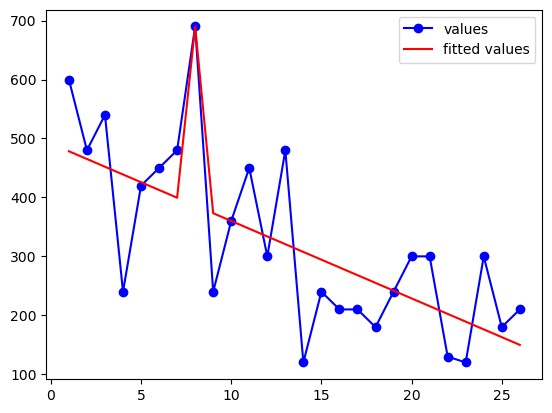

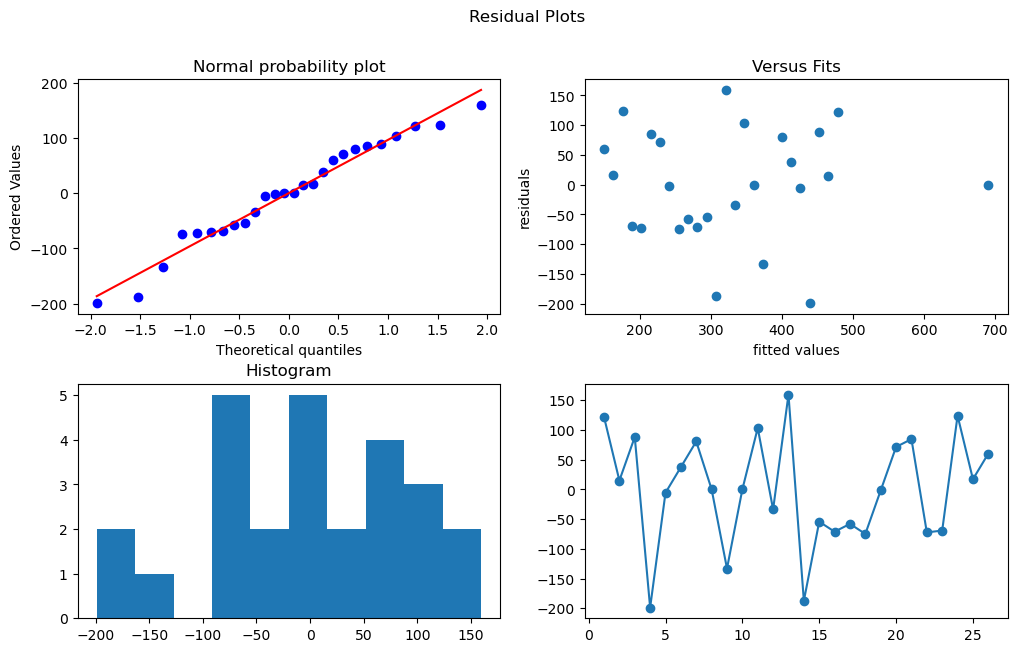

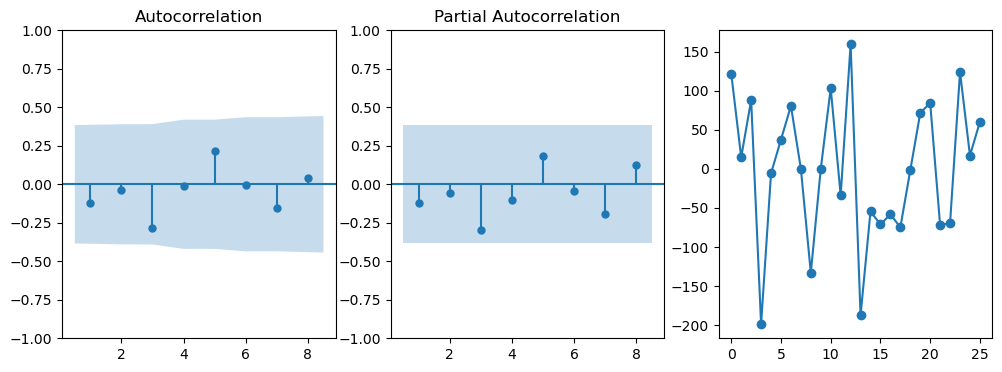

(residuals) Runs test p-value = 0.22976627046113807 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(residuals) ADF test p-value = 1.217435013027013e-06 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low
(residuals) Normality p-value = 0.5299242734909058 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


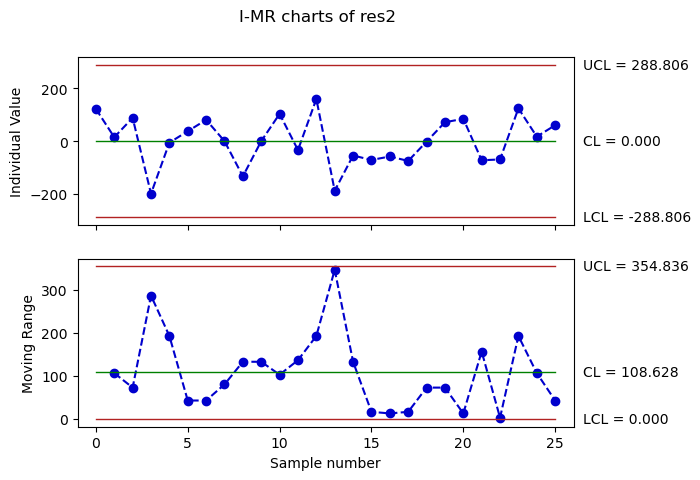

In [84]:
# Create the dummy variable X
data['dummy'] = np.where((data['t'] == 8), 1, 0)
print(data.head())

# re-Fit a model
x = data[['t', 'dummy']]
x = sm.add_constant(x)
y = data['time']
model2 = sm.OLS(y,x).fit()
qda.summary(model2)

plt.plot(data['t'],data['time'], label="values",color='b', linestyle='-', marker='o')
plt.plot(data['t'], model2.fittedvalues, label="fitted values",color='r')
plt.legend()
plt.show()

check_residuals(model2)

# Make a new dataframe for the new residuals
df_res2 = pd.DataFrame({'res2': model2.resid})
# Create the IMR chart
df_res2 = qda.ControlCharts.IMR(df_res2, 'res2')

## Time series models (ARMA)

     I   MR     I_UCL      I_CL     I_LCL  MR_UCL   MR_CL  MR_LCL  I_TEST1  \
0  200  NaN  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
1  202  2.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
2  208  6.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
3  204  4.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   
4  204  0.0  210.3226  203.0278  195.7329  8.9609  2.7429       0      NaN   

   MR_TEST1  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


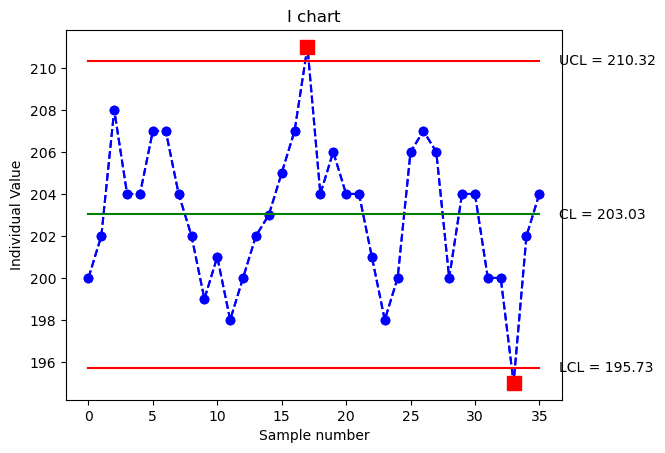

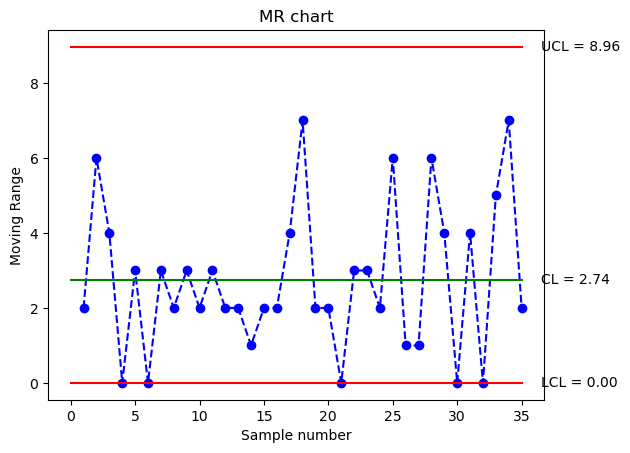

In [129]:
data = pd.read_csv("./Lab7/ESE7_ex2.csv")

###### taken from IMR section above
COL_NAME = "temp"
# Compute the moving ranges using the diff function
data['MR'] = data[COL_NAME].diff().abs()
# Print out descriptive statistics of MR and time
# data.describe()

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={COL_NAME:'I'}, inplace=True)

# Define the control limits (with n=2)
d2 = 1.128 
D4 = 3.267

# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0
# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

print(df.head())

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# MR chart
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

We see something strange so we try to fit a model.  
Indeed the assumptions were not satisfied as we see later.

### some TS code

In [ ]:
# calculate the lag k from data
k=1
data['lagk'] = data[COLNAME].shift(k)
# create scatterplot with regression line using seaborn and set axis labels
sns.regplot(x=data['lagk'], y=data[COLNAME], ci=None, line_kws={'color':'red', 'ls':'--'})
plt.title('Scatter plot of X(t-k) vs X(t)')
plt.xlabel('X(t-k)')
plt.ylabel('X(t)')
plt.title('Scatter plot of X(t-k) vs X(t)')
plt.grid()
plt.show()

# calculate the difference between the data and the lagk
data['diffk'] = data[COLNAME] - data['lagk']
# plot it
plt.plot(data['diffk'], 'o-')
plt.xlabel('Index')
plt.ylabel('DIFF k')
plt.title('Time series plot of DIFF k')
plt.grid()
plt.show()

n = len(data['diffk'][k:])

#autocorrelation function
[acf_values, lbq, _] = acf(data['diffk'][k:], nlags = int(np.sqrt(n)), qstat=True, fft = False)

# Bartlett's test at lag k
# to check if lag k correlation is significant
alpha = 0.05
lag_test = k
rk = acf_values[lag_test]
z_alpha2 = stats.norm.ppf(1-alpha/2)
print('Test statistic rk = %f' % rk)
print('Rejection region is at +-%f' % (z_alpha2/np.sqrt(n)))

### Fitting
> if ACF shows exp decay (or sinusoidal pattern)  $\implies$ AR(p) where p the significance index in PACF  
> if PACF shows exp decay (or sinusoidal pattern) $\implies$ MA(q) where q the significance index in ACF
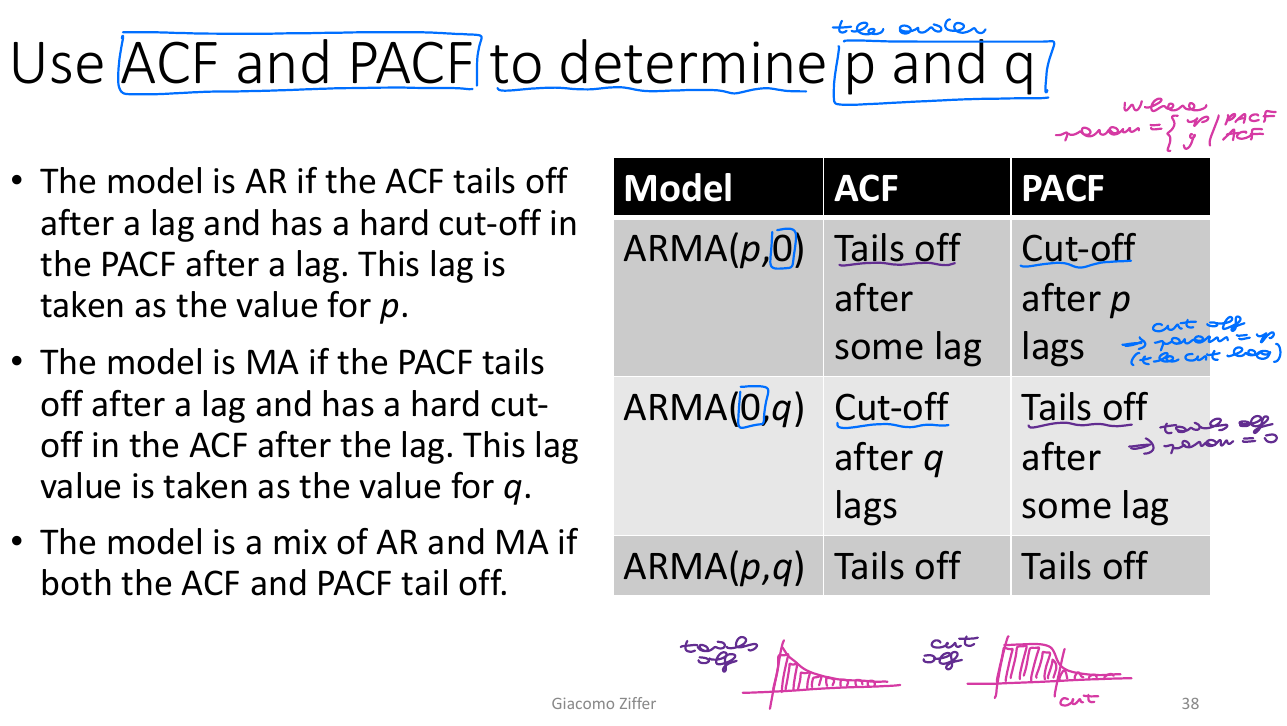

In [ ]:
# Fit an ARIMA model
orders = (p, # AR(p)
		  d, # I(d)
		  q) # MA(q)from statsmodels.tsa.arima.model import ARIMA
arma_model = tsa.ARIMA(data['temp'], order=orders)
# use this if you dont want the constant termn (eg if it is not significant)
# arma_model = tsa.ARIMA(data['temp'], order=orders, trend='n') 
arma_model = arma_model.fit()

# Print model summary
print(arma_model.summary())
# Get the residuals
residuals = arma_model.resid
check_residuals(arma_model)

In [ ]:
##### prediction?
# Forecast pointwise
print(arma_model.forecast(steps=1, alpha=0.05))
# Forecast interval
fcast_res = arma_model.get_forecast()
print(">>> forecast summary:\n", fcast_res.summary_frame(alpha=0.05), "\n")

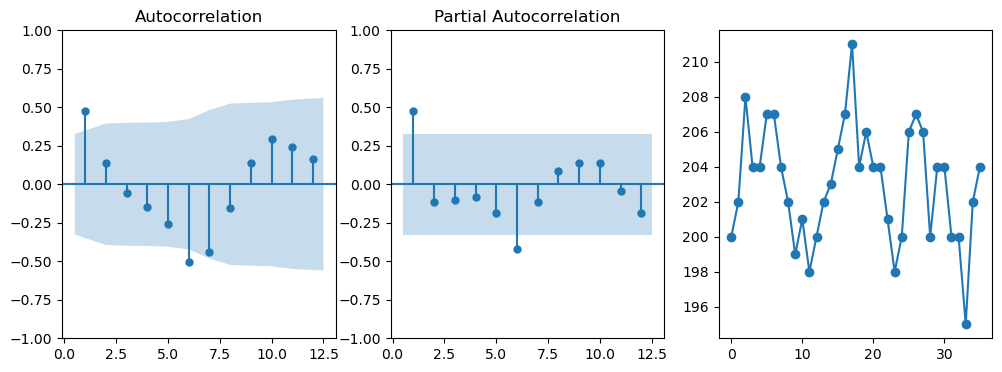

() Runs test p-value = 0.0024081436755146097 - Random data at alpha 5%? False
H0 is "data are random" => conclusion is good if pvalue is high
() ADF test p-value = 0.0001028960013753305 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low


In [158]:
check_randomness(data[COL_NAME])
# So here for example seems suitable an AR(1)

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                   36
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -89.242
Date:                Thu, 13 Jun 2024   AIC                            184.484
Time:                        15:33:24   BIC                            189.235
Sample:                             0   HQIC                           186.142
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        202.9781      0.899    225.880      0.000     201.217     204.739
ar.L1          0.4774      0.162      2.943      0.003       0.159       0.795
sigma2         8.2717      2.318      3.568      0.0

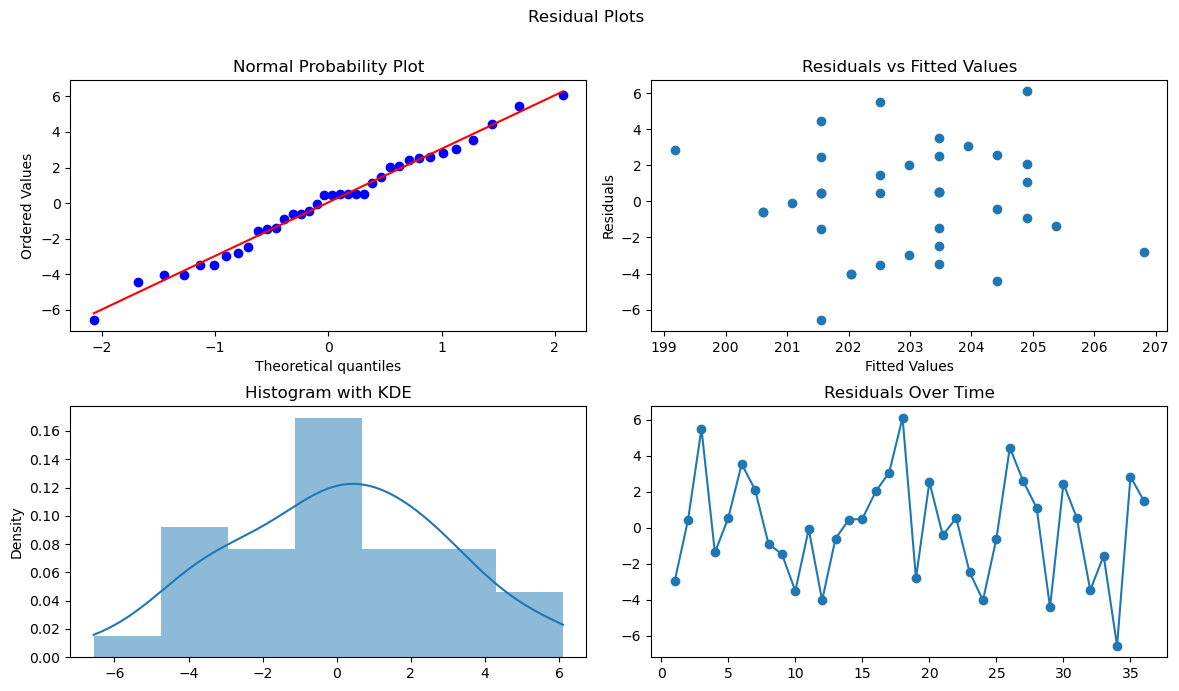

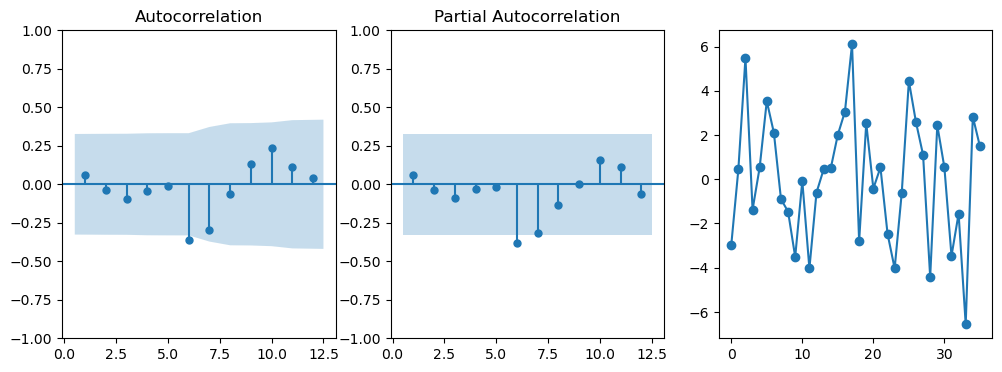

(Residuals) Runs test p-value = 0.3178022433190164 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(Residuals) ADF test p-value = 0.00036487447266954175 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low
(Residuals) Normality p-value = 0.9610901474952698 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [172]:
# Fit an ARIMA model
orders = (1, # AR(p)
		  0, # I(d)
		  0) # MA(q)
from statsmodels.tsa.arima.model import ARIMA
arma_model = tsa.ARIMA(data['temp'], order=orders)
arma_model = arma_model.fit()

# Print model summary
print(arma_model.summary())
# Get the residuals
residuals = arma_model.resid
check_residuals(arma_model)

   temp   MR  temp_lag1
0   200  NaN        NaN
1   202  2.0      200.0
2   208  6.0      202.0
3   204  4.0      208.0
4   204  0.0      204.0
REGRESSION EQUATION
-------------------
temp =  + 105.800 const + 0.479 temp_lag1

COEFFICIENTS
------------
     Term     Coef  SE Coef  T-Value  P-Value
    const 105.7999  30.5748   3.4604   0.0015
temp_lag1   0.4794   0.1506   3.1833   0.0032

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.9664 0.2349     0.2117

ANALYSIS OF VARIANCE
---------------------
    Source   DF   Adj SS   Adj MS  F-Value  P-Value
Regression  1.0  89.1649  89.1649  10.1332   0.0032
     const  1.0 105.3642 105.3642  11.9741   0.0015
 temp_lag1  1.0  89.1649  89.1649  10.1332   0.0032
     Error 33.0 290.3779   8.7993      NaN      NaN
     Total 34.0 379.5429      NaN      NaN      NaN


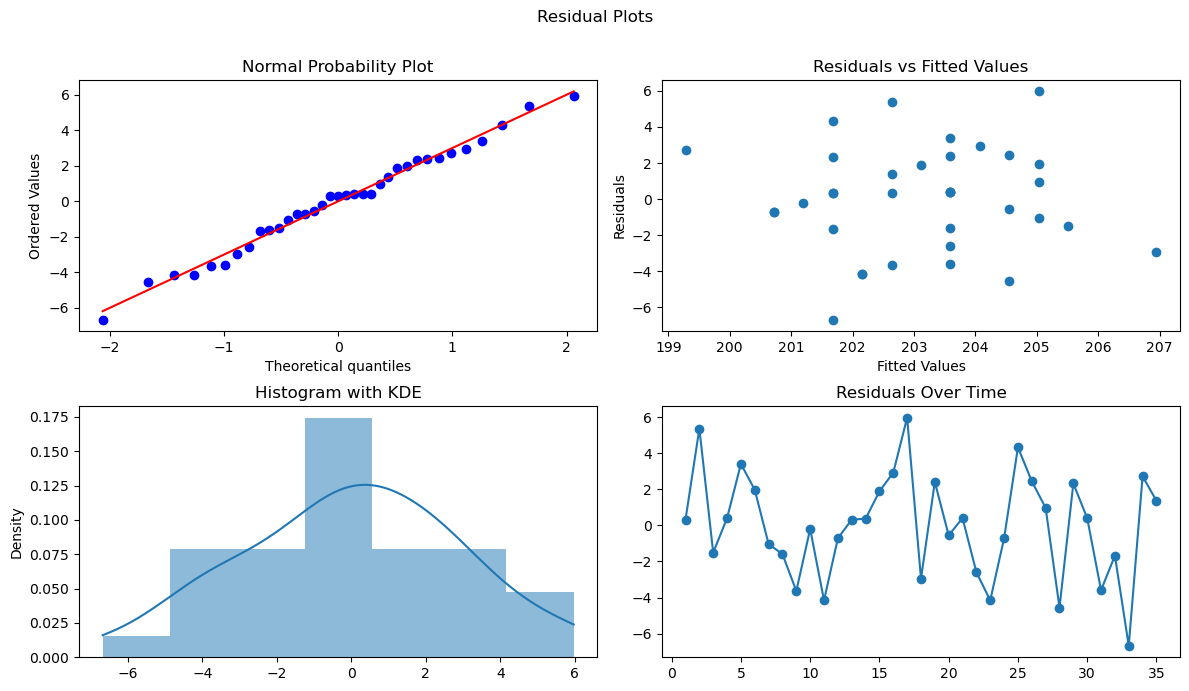

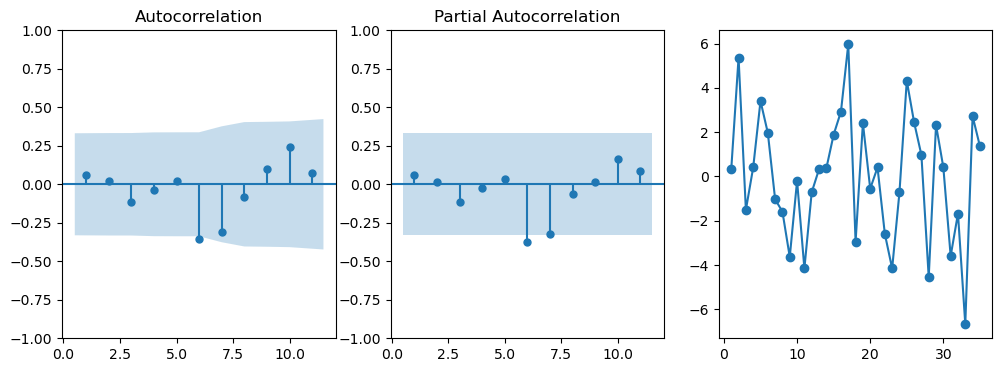

(Residuals) Runs test p-value = 0.2437297147615337 - Random data at alpha 5%? True
H0 is "data are random" => conclusion is good if pvalue is high
(Residuals) ADF test p-value = 0.0006639905208543175 - Stationarity at alpha 5%? True
H0 is "data has a unit root (non-stationary)" => conclusion is good if p-value is low
(Residuals) Normality p-value = 0.9538149237632751 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [175]:
# Add a column with the lagged temperature to use as regressor
data['temp_lag1'] = data['temp'].shift(1)
print(data.head())
# Fit the linear regression model
import statsmodels.api as sm
x = data['temp_lag1'][1:]
x = sm.add_constant(x) # this command is used to consider a constant to the model
y = data['temp'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

check_residuals(model)

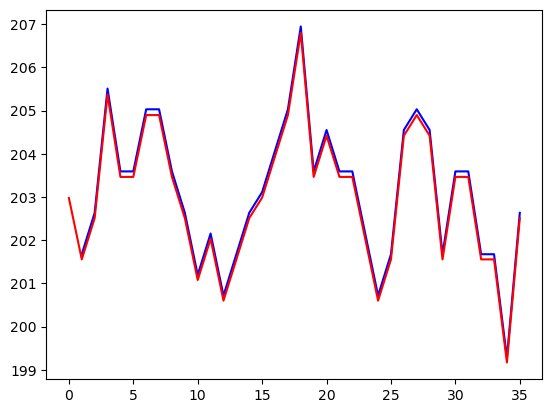

In [178]:
plt.plot(model.fittedvalues,'b-')
plt.plot(arma_model.fittedvalues,'r-')
# both approaches give the almost-same result

### SCC

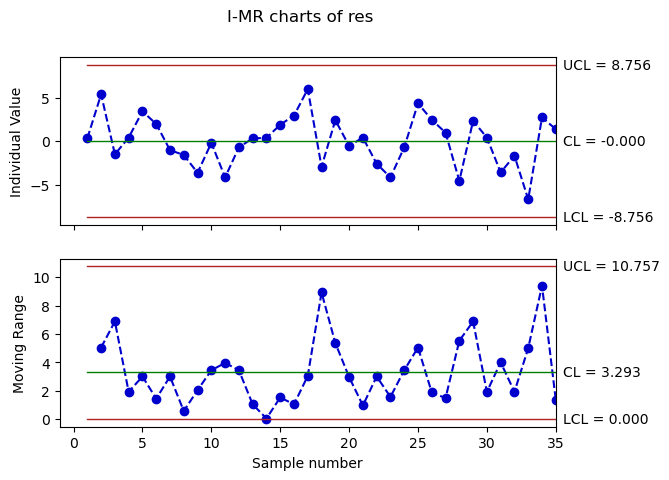

In [183]:
# Put the residuals in a dataframe
df_SCC = pd.DataFrame(model.resid, columns=['res'])
# Plot the IMR control chart
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res')

### FVC

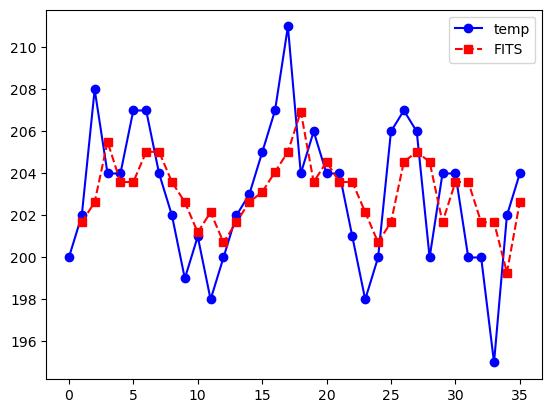

In [181]:
plt.plot(data[COL_NAME], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

### Trend chart

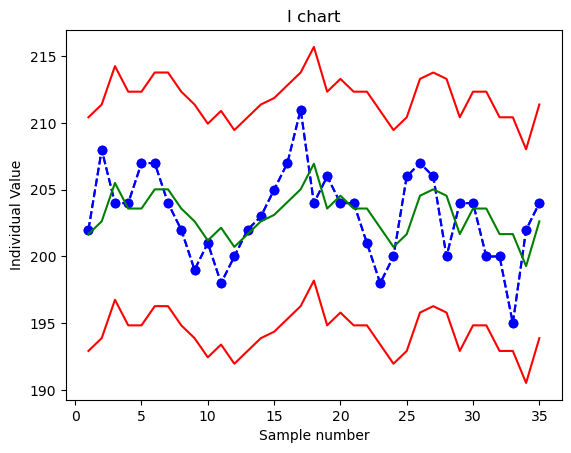

In [185]:
df_SCC = pd.DataFrame(model.resid, columns=['res'])
df_SCC_IMR = qda.ControlCharts.IMR(df_SCC, 'res',plotit=False)

d2 = qda.constants.getd2(2)
MRbar_res = df_SCC_IMR['MR_CL'].iloc[0]

# Create a new dataframe with the original data and the center line (the fitted values)
df = pd.DataFrame({'I': data[COL_NAME].iloc[1:], 'I_CL': model.fittedvalues}, index=data.index[1:])

# Add the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + 3 * MRbar_res / d2
df['I_LCL'] = df['I_CL'] - 3 * MRbar_res / d2

# Add the TEST1 column
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | (df['I'] < df['I_LCL']), df['I'], np.nan)

# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

## IMR-R charts
(ie the case of data n>1 and unstackable since we dont know the within sample time order)

In the case $n>1$, if we know the within sample order we can just stack the data, creating the big vector, and we proceed as before, that is:

In [191]:
data = pd.read_csv('./Lab7/ESE7_ex3.csv')
print(data.head())

# Transpose the dataset and stack the columns
data_stack = data.transpose().melt()
# Remove unnecessary columns
data_stack = data_stack.drop('variable', axis=1)
print(data_stack.head())


    x1   x2   x3   x4
0  456  458  439  448
1  459  462  495  500
2  443  453  457  458
3  470  450  478  470
4  457  456  460  457
   value
0    456
1    458
2    439
3    448
4    459


Instead, if we dont know it, the XbarR charts may be inappropriate if there is violation of assumption of independence within the samples. We see it from the control limits of the Xbar chart looking to narrow with respect to the natural variabilty of the statistic.  

**Solution**: design
- a "between groups" control chart (MR chart), and 
- a "within groups" control chart (R chart) 

With the I chart we can get rid of the violation of the independece assumption within the
sample. The MR chart allows monitoring the between sample variability, while the R chart
designed before can still be used to monitor the within sample variability. 

    x1   x2   x3   x4
0  456  458  439  448
1  459  462  495  500
2  443  453  457  458
3  470  450  478  470
4  457  456  460  457


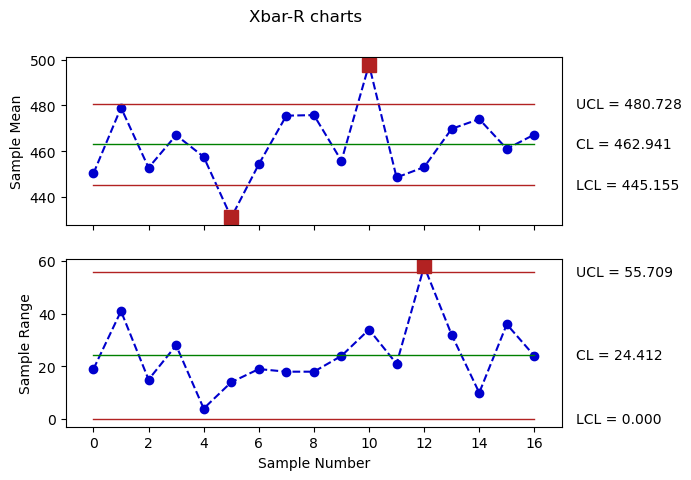

In [195]:
# Import the dataset
data = pd.read_csv('./Lab7/ESE7_ex3.csv')
# Inspect the dataset
print(data.head())

data_XR = qda.ControlCharts.XbarR(data)

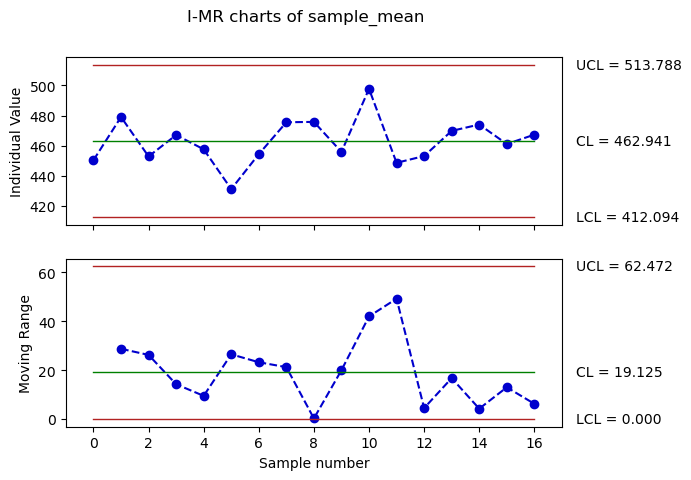

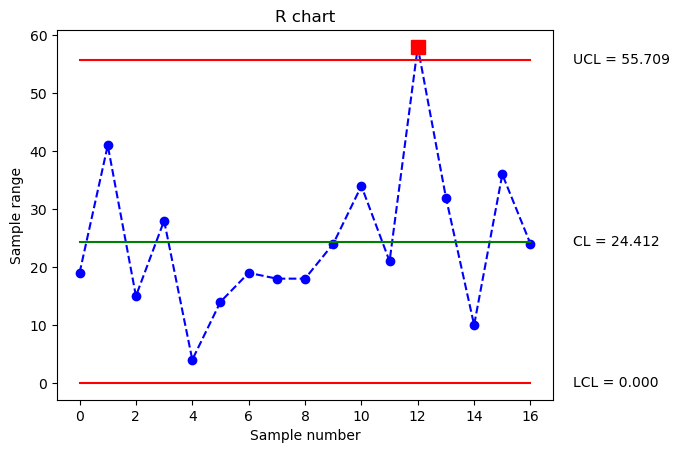

In [196]:
# Design a I-MR-R control chart
# Create a new dataframe that stores the mean of all the samples
data_Xbar = pd.DataFrame(data_XR['sample_mean'])
# Build the IMR chart using this new dataframe
data_Xbar = qda.ControlCharts.IMR(data_Xbar, 'sample_mean')

# Plot the R chart as well
plt.title('R chart')
plt.plot(data_XR['sample_range'], color='b', linestyle='--', marker='o')
plt.plot(data_XR['R_UCL'], color='r')
plt.plot(data_XR['R_CL'], color='g')
plt.plot(data_XR['R_LCL'], color='r')
plt.ylabel('Sample range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_XR)+.5, data_XR['R_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_XR['R_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_CL'].iloc[0], 'CL = {:.3f}'.format(data_XR['R_CL'].iloc[0]), verticalalignment='center')
plt.text(len(data_XR)+.5, data_XR['R_LCL'].iloc[0], 'LCL = {:.3f}'.format(data_XR['R_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_XR['R_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

# ■ Multivariate SPC (Lab 8)

## Case n>1

In [4]:
# Import the dataset
data = pd.read_csv('Lab8/ESE8_ex1.csv')
print(data.shape)
data.head()

(10, 7)


,Boat,Width1,Width2,Width3,Corr.speed1,Corr.speed2,Corr.speed3
0,1,2.14,2.01,1.88,0.33,0.47,0.50
1,2,1.96,1.91,1.94,0.37,0.62,0.37
2,3,1.93,1.86,1.99,0.54,0.57,0.39
3,4,1.94,1.96,1.86,0.52,0.45,0.72
4,5,1.94,2.13,2.17,0.66,0.53,0.33


So we have p=2 covariates, n=3 observations inside each sample, and m=10 samples.  

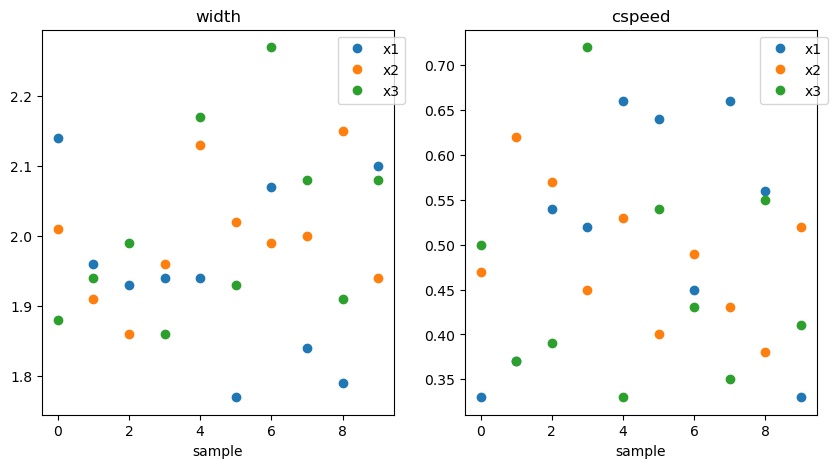

In [5]:
# Extract the stacked array
COVA1 = data[['Width1', 'Width2', 'Width3']]
COVA2 = data[['Corr.speed1', 'Corr.speed2', 'Corr.speed3']]
COVA1_name = "width"
COVA2_name = "cspeed"

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(COVA1, 'o', label = ["x1","x2","x3"])
ax[0].set_xlabel('sample')
ax[0].set_title(COVA1_name)
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=1)

ax[1].plot(COVA2, 'o', label = ["x1","x2","x3"])
ax[1].set_xlabel('sample')
ax[1].set_title(COVA2_name)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=1)

plt.show()

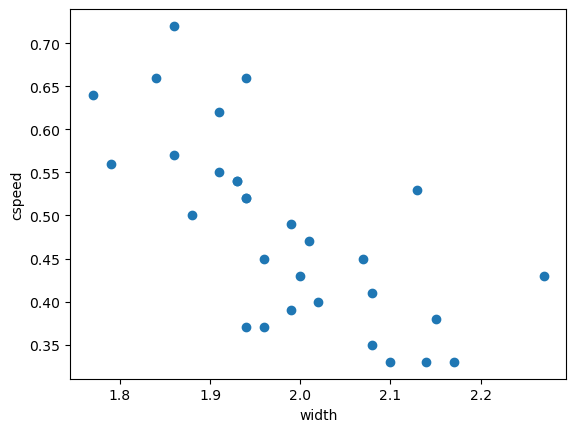

In [9]:
# Plot the stacked-covariates, to see correlation
# if there is correlation -> multivariate charts should be better
plt.scatter(COVA1, COVA2)
plt.xlabel(COVA1_name)
plt.ylabel(COVA2_name)
plt.show()

### Assumptions:
We need to check assumptions:
- marginal normality on the stacked values of each covariate
- randomness/independence if we know the within sample order

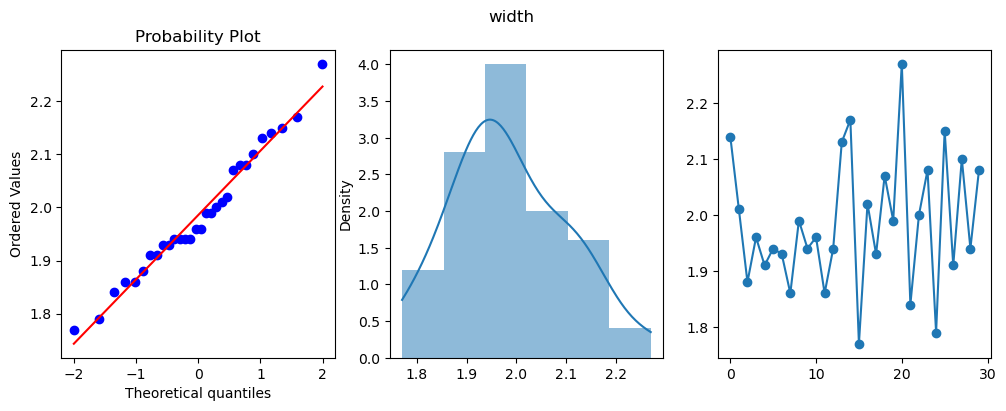

(width) Normality p-value = 0.7043676376342773 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


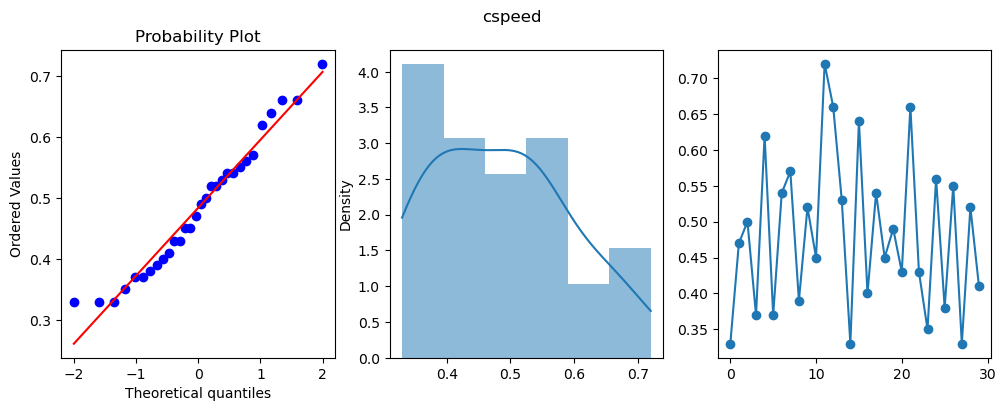

(cspeed) Normality p-value = 0.24947109818458557 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [48]:
check_gaussianity(COVA1.stack(),COVA1_name)
check_gaussianity(COVA2.stack(),COVA2_name)

### Estimated parameters
$$ 
T_k^2 = n(\pmb{\bar{x}}_k - \pmb{\bar{\bar{x}}})^T S^{-1} (\pmb{\bar{x}}_k - \pmb{\bar{\bar{x}}}) \quad k=1,\ldots,m
$$
with the control limits
$$\begin{align*}
&\text{UCL} =c(m,n,p) \cdot q_\alpha^{F(p,m(n-1)-(p-1))}\\ 
&\text{LCL} = 0
\end{align*}\\
c(m,n,p) = \begin{cases} 
\dfrac{p(n-1)(m-1)}{m(n-1)-(p-1)} & \text{phase1}\\
\dfrac{p(n-1)(m+1)}{m(n-1)-(p-1)} & \text{phase2}
\end{cases}
$$
where m is the number of samples collected for phase 1.   
So for large m we can also go to the asymptotic limits
$$\begin{align*}
&\text{UCL} = q_\alpha^{\chi^2(p)}\\ 
&\text{LCL} = 0
\end{align*}
$$

In [97]:
#### compute Xbarbar
sample_mean = pd.DataFrame()
sample_mean[COVA1_name] = COVA1.mean(axis=1)
sample_mean[COVA2_name] = COVA2.mean(axis=1)
# Calculate grand mean
Xbarbar = sample_mean.mean()
print("-----Xbarbar-----\n",Xbarbar)

#### compute S
data_stack = pd.DataFrame()
data_stack[['sample', COVA1_name]] = COVA1.transpose().melt()
data_stack[COVA2_name] = COVA2.transpose().melt()['value']
# print(data_stack.head())
# Compute the variance and covariance matrix of each group (sample)
cov_matrix = data_stack.groupby('sample').cov()
# print(cov_matrix.head())

# Compute the mean covariance matrix
S = cov_matrix.groupby(level=1).mean()
print("-----S old-----\n",S)# indeces are in alphabetic order
# # Reorder the indeces of S to match the order of the columns
cols = S.columns.tolist()
S = S.reindex(columns=cols, index=cols)
print("-----S reindexed-----\n",S)

-----Xbarbar-----
 width     1.985333
cspeed    0.483667
dtype: float64
-----S old-----
            width    cspeed
cspeed -0.010970  0.014633
width   0.013263 -0.010970
-----S reindexed-----
            width    cspeed
width   0.013263 -0.010970
cspeed -0.010970  0.014633


UCL = 6.673


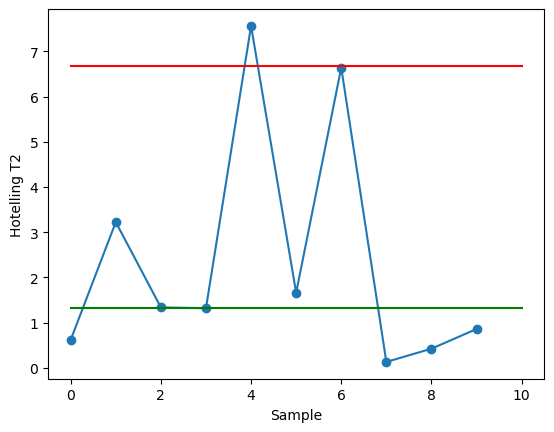

In [59]:
# create the chart/control limits
S_inv = np.linalg.inv(S)
p = 2             # number of covariates
m = data.shape[0] # number of samples in phase1
n = 3             # number of obs inside each sample (sample size)
alpha = 0.05      # significance level

UCL = (p*(m-1)*(n-1)) / (m*(n-1)-(p-1)) * stats.f.ppf(1-alpha, p, m*n - m + 1 - p)
print('UCL = %.3f' % UCL)

# Calculate Hotelling T2 statistic for all samples
T2 = []
for i in range(m):
    T2.append(n * (sample_mean.iloc[i]-Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[i]-Xbarbar))

# Plot Hotelling T2 statistic
plt.plot(T2, 'o-')
plt.plot([0, m], [UCL, UCL], 'r-')
plt.plot([0, m], [np.median(T2), np.median(T2)], 'g-')
plt.xlabel('Sample')
plt.ylabel('Hotelling T2')
plt.show()

### Given parameters

In [ ]:
# Define the data
n = 25          # number of replicates (sample size)
p = 2           # number of random variables
alpha = 0.05    # significance level

data = pd.DataFrame({
	'xbar1': [00, 00], 
	'xbar2': [00, 00]
	}, index=['sample1', 'sample2'])

# define the sample mean vector as a pandas series
Xbarbar = pd.Series({'xbar1': 00, 'xbar2': 00})
# define the covariance matrix as a pandas dataframe
S = pd.DataFrame([[1, 0],
				  [0, 1]],
                columns=['xbar1', 'xbar2'],
                index=['xbar1', 'xbar2'])

# Calculate hotelling of first and second sample
S_inv = np.linalg.inv(S) # inverse of the covariance matrix

# Calculate the Hotelling's T2 statistic of the sample 1
T2_1 = n * (data.loc['sample1'] - Xbarbar).transpose().dot(S_inv).dot(data.loc['sample1'] - Xbarbar)
# Calculate the Hotelling's T2 statistic of the sample 2
T2_2 = n * (data.loc['sample2'] - Xbarbar).transpose().dot(S_inv).dot(data.loc['sample2'] - Xbarbar)
print("T2_1 = %.3f" % T2_1)
print("T2_2 = %.3f" % T2_2)

In [66]:
#### compute the limits to decide ic or ooc
# if we know m use the classical approach but with phase2 formula
m = 20 # number of samples of phase 1
c2 = (p*(n-1)*(m+1))/(m*(n-1)-(p-1))
UCL_new = c2*stats.f.ppf(1-alpha, p, (m*(n-1)-(p-1)))
print("UCL_mgiven = %.4f" % UCL_new)

# if we just know "m is large" use chi squared asymptotic
# Calculate the UCL of the Hotelling's T2 statistic
UCL = stats.chi2.ppf(1-alpha, p)
print("UCL_mlarge = %.4f" % UCL)

UCL_mgiven = 6.3438
UCL_mlarge = 5.9915


### Known parameters
Just use the estimated parameters section with chi squared limits.  
I wrote this code but i dont know it if works properly.

UCL = 5.991


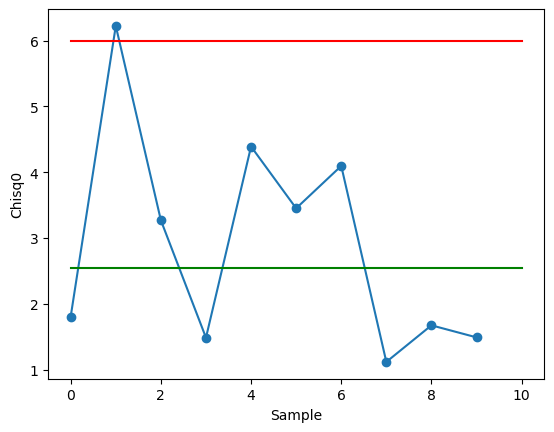

In [105]:
# define the sample mean vector as a pandas series
mu = pd.Series({COVA1_name: 2, COVA2_name: 0.5})
# define the covariance matrix as a pandas dataframe
Sigma = pd.DataFrame([[0.013, -0.011],
				  [-0.011, 0.015]],
                columns=[COVA1_name, COVA2_name],
                index=[COVA1_name, COVA2_name])

# create the chart/control limits
Sigma_inv = np.linalg.inv(Sigma)
p = 2             # number of covariates
m = data.shape[0] # number of samples in phase1
n = 3             # number of obs inside each sample (sample size)
alpha = 0.05      # significance level

UCL = stats.chi2.ppf(1-alpha, p)
print('UCL = %.3f' % UCL)

# precompute incremental means Xbar --- NO
# incremental_mean_COVA1 = (COVA1.mean(axis=1)).expanding().mean()
# incremental_mean_COVA2 = (COVA2.mean(axis=1)).expanding().mean()

# Calculate Hotelling Chisq0 statistic for all samples
Chisq0 = []
for i in range(m):
    current_Xbar = pd.Series({
        # COVA1_name: incremental_mean_COVA1[i], 
        # COVA2_name: incremental_mean_COVA2[i] --- NO
        COVA1_name: COVA1.mean(axis=1)[i], 
        COVA2_name: COVA2.mean(axis=1)[i]
        })
    Chisq0.append(n * (current_Xbar-mu).transpose().dot(Sigma_inv).dot(current_Xbar-mu))

# Plot Hotelling Chisq0 statistic
plt.plot(Chisq0, 'o-')
plt.plot([0, m], [UCL, UCL], 'r-')
plt.plot([0, m], [np.median(Chisq0), np.median(Chisq0)], 'g-')
plt.xlabel('Sample')
plt.ylabel('Chisq0')
plt.show()

### Multiple univariate charts 

In [ ]:
##### exact params
# Covariates data
p = 3
n = SAMPLE_SIZE
mu_x = 10
var_x = 1
mu_y = 12
var_y = 1.5
mu_z = 13
var_z = 2

# Calculate the Z
alpha_FAM = 0.005 # eg
alpha = alpha_FAM / p
Zalpha = stats.norm.ppf(1-alpha/2)
print("alpha_FAM = %f " % alpha_FAM)
print("alpha = %f " % alpha)
print("Z alpha/2 = %.3f " % Zalpha)

# Compute the control limits of the variables x,y,z
UCL_x = mu_x + Zalpha*np.sqrt(var_x)/np.sqrt(n)
CL_x = mu_x
LCL_x = mu_x - Zalpha*np.sqrt(var_x)/np.sqrt(n)

UCL_y = mu_y + Zalpha*np.sqrt(var_y)/np.sqrt(n)
CL_y = mu_y
LCL_y = mu_y - Zalpha*np.sqrt(var_y)/np.sqrt(n)

UCL_z = mu_z + Zalpha*np.sqrt(var_z)/np.sqrt(n)
CL_z = mu_z
LCL_z = mu_z - Zalpha*np.sqrt(var_z)/np.sqrt(n)

# Print a table with the control limits
data = pd.DataFrame({'UCL': [UCL_x, UCL_y, UCL_z],
'CL': [CL_x, CL_y, CL_z],
'LCL': [LCL_x, LCL_y, LCL_z]}, index = ['x', 'y', 'z'])
print(data)

In [ ]:
##### estimated params
# Bonferroni correction
p = NCOVA # number of covariates
alpha_fam = 0.005  # eg
alpha=alpha_fam/p
K_alpha = stats.norm.ppf(1-alpha/2)

for col in data.columns:
	data_cc=pd.DataFrame(data[col])
	data_IMR = qda.ControlCharts.IMR(data_cc,col,K = K_alpha)

### PCA
PCA does not require the normality assumptions, but the control chart to be designed on the first PC requires
both normality and randomness assumption.  
When monitoring a process in the PC space, it is a common practice to combine a control chart on first
retained PCs with a control charts on the PCA model residuals, which is helpful to detect anomalies that do
not affect the first PCs but only the remaining ones, preventing any information loss.

In [ ]:
# Import the dataset
data = pd.read_csv('')
print(data.shape)
data.head()

In [ ]:
# Scatter plot
pd.plotting.scatter_matrix(data, alpha = 1)
plt.show()

# Variance covariance matrix
cov_matrix = data.cov()
print(cov_matrix)

# Correlation covariance matrix
corr_matrix = data.corr()
print(corr_matrix)
# The sample correlation matrix coincides with the sample variance covariance
# matrix of standardized variables!

# Boxplot
data.boxplot()
plt.show() 

In [ ]:
# Standardize data (if needed)
data_std = (data - data.mean()) / data.std()
data_std.head(10)

In [ ]:
# Create the PCA object
pca = PCA()
# Fit the PCA object to the data
pca.fit(data_std)

# print("Eigenvalues \n", pca.explained_variance_)
# print("\nEigenvectors \n", pca.components_)
# print("\nExplained variance ratio \n", pca.explained_variance_ratio_)

print("\nCumulative explained variance ratio \n", np.cumsum(pca.explained_variance_ratio_))

# Plot the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
# add a bar chart to the plot
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance)
plt.xlabel('Component number')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance')
plt.show()

In [ ]:
# Compute the scores (i.e. all the principal components, n x 3) 
scores = pca.transform(data_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores,columns = ['z1', 'z2', 'z3','z4'])
# Print the first rows of the scores dataframe
scores_df.head()

# Scatter plot of the scores
plt.plot(scores_df['z1'],scores_df['z2'],'o')
for i in range(len(scores_df)):
    plt.text(scores_df['z1'][i], scores_df['z2'][i], str(i))
plt.show()
# or this
pd.plotting.scatter_matrix(scores_df, alpha = 1)
plt.show()

In [ ]:
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.show()

In [ ]:
# Loadings
# Plot only the first k PCs
k = 3
fig, ax = plt.subplots(k,1, figsize = (15, 10))
for i in range(k):
   ax[i].plot(pca.components_[i], 'o-')
   ax[i].set_title('Loading ' + str(i+1))
   plt.xticks(ticks=np.arange(0, 6, step=1), labels=data.columns)

In [ ]:
# Compute the reconstructed data using the first k principal components

reconstructed_data_std = scores_df[['', '']].dot(pca.components_[0:k, :])
# Now use the mean and standard deviation to compute the reconstructed data
reconstructed_data = reconstructed_data_std.dot(np.diag(data.std())) + np.asarray(data.mean())

# Compare the original data with the reconstructed data
print("Original data\n", data.head())
print("\nReconstructed (ORIGINAL) data\n", reconstructed_data.head())

## Case n=1

### Assumptions

In [10]:
# Import the data
data = pd.read_csv('./Lab8/ESE8_ex4.csv')
# drop the sample column
data = data.drop('Sample', axis=1)

print(data.shape)
print(data.head())

(30, 2)
      x1     x2
0  11.09  20.28
1   9.33  19.01
2  10.95  20.96
3  10.53  21.33
4  11.95  22.51


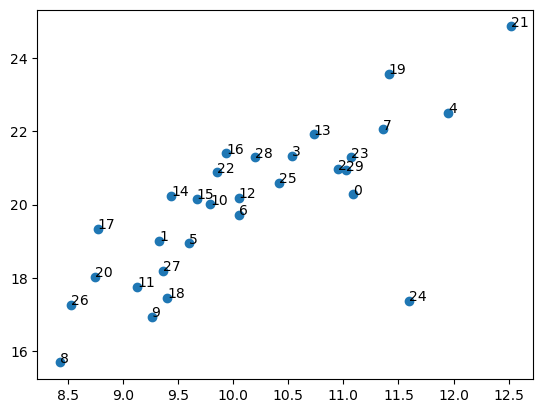

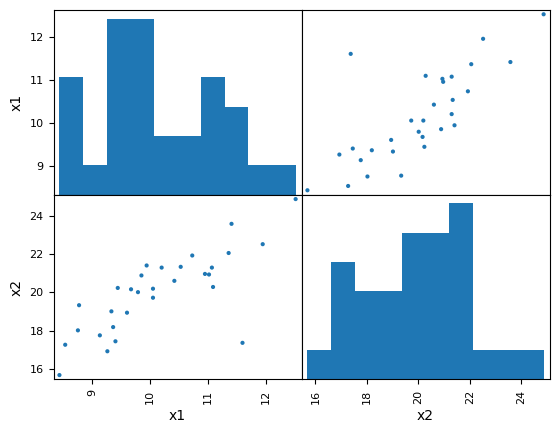

In [13]:
plt.plot(data['x1'],data['x2'],'o')
for i in range(len(data)):
    plt.text(data['x1'][i], data['x2'][i], str(i))

# or also this
pd.plotting.scatter_matrix(data, alpha = 1)
plt.show()

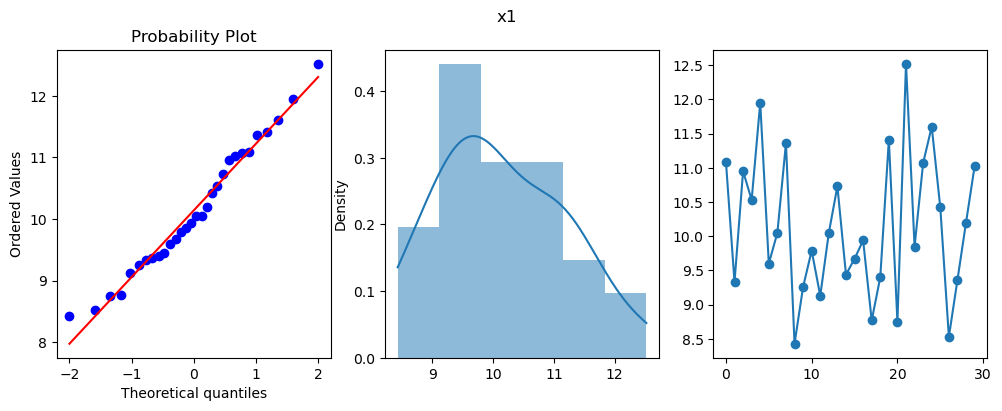

(x1) Normality p-value = 0.6172055602073669 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


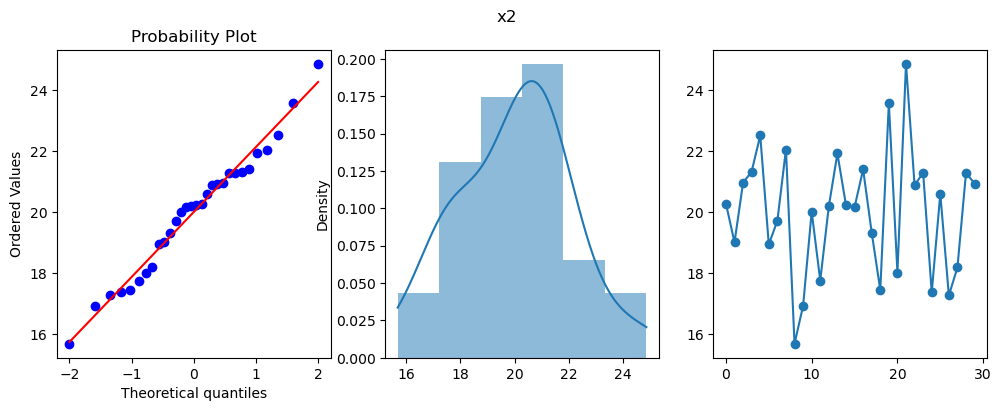

(x2) Normality p-value = 0.8685551881790161 - Normality at alpha 5%? True
H0 is "data are gaussian" => conclusion is good if pvalue is high


In [11]:
check_gaussianity(data['x1'],"x1")
check_gaussianity(data['x2'],"x2")
# check_randomness(data['x1'],"x1")
# check_randomness(data['x2'],"x2")

### Known parameters

In [148]:
# Define the parameters
mu_1 = 10; mu_2 = 20
std_1 = 1; std_2 = 2
corr = 0.8

# Create the mean vector
mu = pd.Series({'x1': mu_1, 'x2': mu_2})

# Create the variance/covariance matrix
covariance = corr * std_1 * std_2 # rho = sij / (si * sj)
var_1 = std_1**2; var_2 = std_2**2
S = pd.DataFrame([[var_1, covariance],
				  [covariance, var_2]],
                columns=['x1', 'x2'],
                index=['x1', 'x2'])
# inverse of the variance/covariance matrix
S_inv = np.linalg.inv(S) 

print("---mu---\n", mu)
print("---Sigma---\n", S)

---mu---
 x1    10
x2    20
dtype: int64
---Sigma---
      x1   x2
x1  1.0  1.6
x2  1.6  4.0


In [149]:
alpha = 0.0027 # significance level
n = 1          # sample size
m = len(data)  # number of samples
p = 2          # number of variables

# Calculate the upper control limit
UCL = stats.chi2.ppf(1 - alpha, df = p)

# Add an empty column to the dataframe to store the Chi2 statistic
data_CC = data.copy()
data_CC['Chi2'] = np.nan

for i in range(m):
    data_CC['Chi2'].iloc[i] = n * (data.iloc[i] - mu).transpose().dot(S_inv).dot(data.iloc[i] - mu)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['Chi2_UCL'] = UCL
data_CC['Chi2_CL'] = data_CC['Chi2'].median()
data_CC['Chi2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['Chi2_TEST'] = np.where((data_CC['Chi2'] > data_CC['Chi2_UCL']), data_CC['Chi2'], np.nan)

# Inspect the dataset
data_CC.head()

,x1,x2,Chi2,Chi2_UCL,Chi2_CL,Chi2_LCL,Chi2_TEST
0,11.09,20.28,2.676500,11.829007,1.262424,0,NaN
1,9.33,19.01,0.453569,11.829007,1.262424,0,NaN
2,10.95,20.96,1.120278,11.829007,1.262424,0,NaN
3,10.53,21.33,0.442236,11.829007,1.262424,0,NaN
4,11.95,22.51,4.060903,11.829007,1.262424,0,NaN


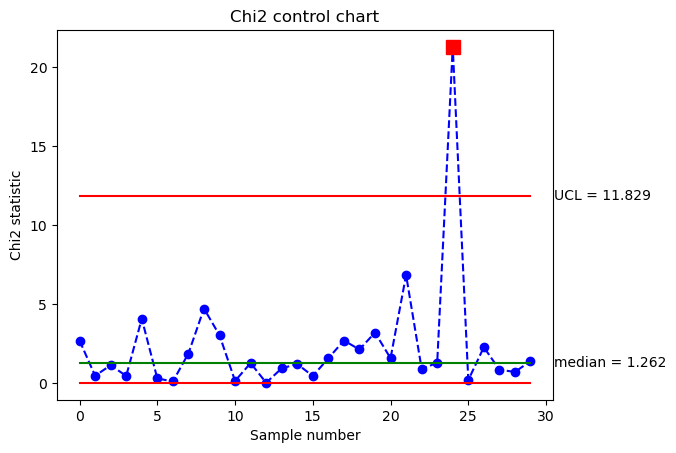

In [160]:
# Plot the Chi2 control chart
plt.title('Chi2 control chart')
plt.plot(data_CC['Chi2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['Chi2_UCL'], color='r')
plt.plot(data_CC['Chi2_CL'], color='g')
plt.plot(data_CC['Chi2_LCL'], color='r')
plt.ylabel('Chi2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['Chi2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['Chi2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['Chi2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['Chi2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['Chi2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [165]:
get_ooc(data_CC)

Index 24 has not-null value in column ['Chi2_TEST']


### Estimated parameters
After checking the usual assumptions, we have to estimate the parameters mu and Sigma:
- for mu we have the sample mean
- for sigma we have short-period S and long-period S
The test statistic is 
$$
T^2_k = (\pmb{x}_k-\pmb{\bar{x}})^T S^{-1}(\pmb{x}_k-\pmb{\bar{x}})
$$
where $\pmb{x} = (x_1^{(k)},\ldots,x_p^{(k)})$ is the vector of the covariate values for observation $k$, that is, the k-th row.   
While for the limits we have
$$
\begin{align*}
& \text{phase1}&\\
\text{UCL}& =\frac{(m-1)^2}{m} q_\alpha ^ {\beta(p/2,(m-p-1)/2)}&\\
\text{LCL}& = 0&\\
& \text{phase2 small m} & & \text{phase2 large m}\\
\text{UCL}& =\frac{p(m+1)(m-1)}{m(m-p)} q_\alpha ^ {F(p,m-p)} & \text{UCL}& =\frac{p(m-1)}{m-p} q_\alpha ^ {F(p,m-p)}\\
\text{LCL}& = 0 & \text{LCL}& = 0

\end{align*}
$$

In [170]:
#### Calcolo del vettore medio
Xbar = data.mean(axis=0)
print("----Xbar---\n", Xbar)

#### S short period
# Create the V matrix
V = data.diff().dropna()
# Calculate the short range estimator S2
S2 = 1/2 * V.transpose().dot(V) / (m-1)
S2_inv = np.linalg.inv(S2)
# Display the short range estimator
print("----S short period----\n", S2)

#### S long period
# Inizializzazione della matrice di varianza S
S1 = np.zeros((data.shape[1], data.shape[1]))
# Calcolo della matrice di varianza S
for i in range(m):
    diff = data.iloc[i] - Xbar
    S1 += np.outer(diff, diff)
    # S1 += data.iloc[i]-Xbar.dot(data.iloc[i]-Xbar.transpose())
S1 /= (m - 1)
print("----S long period----\n", S1)
S1_inv = np.linalg.inv(S1)

#### Choose S
S = S2; S_inv = S2_inv # short
S = S1; S_inv = S1_inv # long

----Xbar---
 x1    10.140000
x2    20.004667
dtype: float64
----S short period----
           x1        x2
x1  1.232222  2.001583
x2  2.001583  4.860412
----S long period----
 [[1.10864138 1.6748069 ]
 [1.6748069  4.2911154 ]]


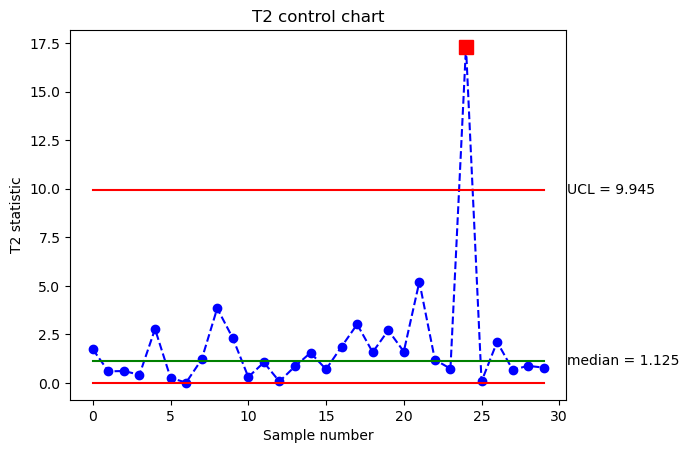

In [171]:
# Build the charts
data_CC = data.copy()
# Calculate the Hotelling T2 statistic
data_CC['T2'] = np.nan
for i in range(m):
    data_CC['T2'].iloc[i] = n * (data.iloc[i] - Xbar).transpose().dot(S_inv).dot(data.iloc[i] - Xbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = ((m-1)**2)/m*stats.beta.ppf(1 - alpha, p/2, (m-p-1)/2)
data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# phase 2 limit
# phase2_UCL = (p*(m-1)*(m+1))/(m*m-m*p)*stats.f.ppf(1 - alpha, p, m-p)

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)
# Inspect the dataset
# data_CC.head()

# Plot the T2 control chart
plt.title('T2 control chart')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()